<a href="https://colab.research.google.com/github/aregeezra/Churn/blob/main/Hypothyroid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0.0 IMPORTS

In [ ]:

import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import datetime              
from tabulate              import tabulate
from scipy.stats           import chi2_contingency
from IPython.display       import Image
from IPython.core.display  import HTML

from sklearn.tree           import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.tree          import DecisionTreeClassifier
from sklearn.ensemble      import RandomForestRegressor
import xgboost as xgb
from sklearn import metrics
import random
import warnings
warnings.filterwarnings( 'ignore' )


##0.1 Helper Function

In [ ]:
#Mean residual Error
def mean_percentage_error( y, yhat):
  return np.mean( (y-yhat ) / y)


# categorical to categorical relationship function
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

# display functions
def settings():
  %matplotlib inline
  %pylab inline
  
  plt.style.use( 'bmh' )
  plt.rcParams['figure.figsize'] = [25, 12]
  plt.rcParams['font.size'] = 24
  
  display( HTML( '<style>.container { width:100% !important; }</style>') )
  pd.options.display.max_columns = None
  pd.options.display.max_rows = None
  pd.set_option( 'display.expand_frame_repr', False )
  
  sns.set()




In [ ]:
settings()

Populating the interactive namespace from numpy and matplotlib


##0.2 Loading Data

In [ ]:
data = pd.read_csv('http://bit.ly/hypothyroid_data')

#1.0 Description of Data

In [ ]:
#first five columns
data.head()

,status,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,thyroid_surgery,query_hypothyroid,query_hyperthyroid,pregnant,sick,tumor,lithium,goitre,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG
0,hypothyroid,72,M,f,f,f,f,f,f,f,f,f,f,f,y,30,y,0.60,y,15,y,1.48,y,10,n,?
1,hypothyroid,15,F,t,f,f,f,f,f,f,f,f,f,f,y,145,y,1.70,y,19,y,1.13,y,17,n,?
2,hypothyroid,24,M,f,f,f,f,f,f,f,f,f,f,f,y,0,y,0.20,y,4,y,1,y,0,n,?
3,hypothyroid,24,F,f,f,f,f,f,f,f,f,f,f,f,y,430,y,0.40,y,6,y,1.04,y,6,n,?
4,hypothyroid,77,M,f,f,f,f,f,f,f,f,f,f,f,y,7.30,y,1.20,y,57,y,1.28,y,44,n,?


In [ ]:
# four random samples in our data
data.sample(4)

,status,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,thyroid_surgery,query_hypothyroid,query_hyperthyroid,pregnant,sick,tumor,lithium,goitre,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG
585,negative,49,F,f,f,f,f,f,f,f,t,f,f,f,y,2.20,y,0.80,y,27,y,0.52,y,52,n,?
88,hypothyroid,63,F,f,f,f,f,f,t,f,f,f,f,f,y,60,y,0.70,y,20,y,1.24,y,16,n,?
234,negative,63,F,t,f,f,f,t,f,f,f,f,f,f,y,0.30,y,1.30,y,130,y,1.05,y,124,n,?
2795,negative,12,M,t,f,f,f,f,f,f,f,f,f,f,y,0.10,y,3,y,176,y,0.89,y,197,n,?


## 1.1 Data Dimensions

In [ ]:
print( 'Number of Rows: {}'.format( data.shape[0] ) )
print( 'Number of Columns: {}'.format( data.shape[1] ) )

Number of Rows: 3163
Number of Columns: 26


## 1.2 Unique values in our dataset

In [ ]:
#Valid column names
data.columns

Index(['status', 'age', 'sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_medication', 'thyroid_surgery', 'query_hypothyroid',
       'query_hyperthyroid', 'pregnant', 'sick', 'tumor', 'lithium', 'goitre',
       'TSH_measured', 'TSH', 'T3_measured', 'T3', 'TT4_measured', 'TT4',
       'T4U_measured', 'T4U', 'FTI_measured', 'FTI', 'TBG_measured', 'TBG'],
      dtype='object')

In [ ]:
#Unique values in each column
for col in data.columns:
  print(f'Unique values in {col}  \n {data[col].unique()} \n')
  print("***********************\n")

Unique values in status  
 ['hypothyroid' 'negative'] 

***********************

Unique values in age  
 ['72' '15' '24' '77' '85' '64' '20' '42' '69' '75' '53' '59' '68' '50'
 '78' '65' '28' '43' '40' '84' '?' '83' '63' '73' '36' '27' '48' '71' '60'
 '34' '79' '62' '74' '32' '41' '70' '29' '5' '58' '35' '51' '22' '16' '44'
 '39' '47' '18' '17' '88' '56' '30' '45' '66' '52' '54' '80' '33' '38'
 '92' '67' '46' '13' '89' '61' '49' '26' '57' '31' '90' '81' '25' '37'
 '76' '87' '23' '55' '86' '98' '21' '97' '1' '6' '14' '82' '11' '19' '9'
 '12' '10' '8' '7' '4' '93'] 

***********************

Unique values in sex  
 ['M' 'F' '?'] 

***********************

Unique values in on_thyroxine  
 ['f' 't'] 

***********************

Unique values in query_on_thyroxine  
 ['f' 't'] 

***********************

Unique values in on_antithyroid_medication  
 ['f' 't'] 

***********************

Unique values in thyroid_surgery  
 ['f' 't'] 

***********************

Unique values in query_hypothyroid  

##1.3 Check NA 

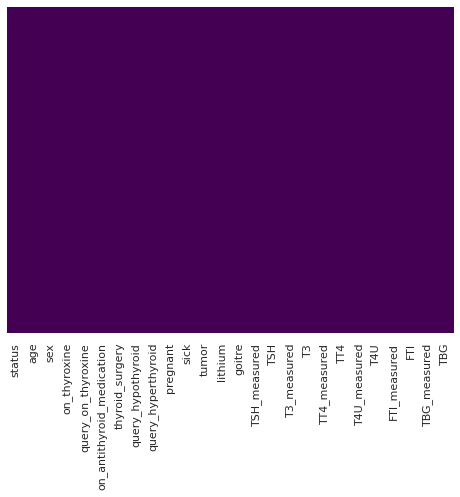

In [ ]:
#No null values in our data 

plt.figure(figsize=(8,6))
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [ ]:
pd.DataFrame({"Missing Values(%)":
              data.isna().sum()/len(data.index)*100})

,Missing Values(%)
status,0.0
age,0.0
sex,0.0
on_thyroxine,0.0
query_on_thyroxine,0.0
on_antithyroid_medication,0.0
thyroid_surgery,0.0
query_hypothyroid,0.0
query_hyperthyroid,0.0
pregnant,0.0


In [ ]:
# finding anomalies '? ' and dealing with them
tests = ['TSH', 'T3','TT4', 'FTI', 'T4U']

for t in tests:
  print(f'Value counts of {t} in Percentage (%): \n {data[t].value_counts()/len(data.index)*100} \n')
  
  print('-------------------------------------------------------------------------------')

Value counts of TSH in Percentage (%): 
 0        28.264306
?        14.796080
0.90      2.402782
0.70      2.371167
0.80      2.181473
0.60      2.055011
1.30      1.928549
0.50      1.896933
1         1.865318
0.30      1.675624
0.40      1.675624
1.40      1.517547
1.20      1.517547
0.20      1.454316
1.10      1.422700
1.50      1.296238
1.60      1.106544
1.70      0.948467
2.10      0.948467
0.15      0.916851
2.20      0.853620
1.80      0.822004
1.90      0.790389
0.25      0.695542
2.30      0.663927
2.70      0.600696
2         0.569080
4         0.505849
3.10      0.474233
3         0.474233
2.60      0.474233
11        0.442618
2.50      0.442618
3.30      0.411002
3.20      0.411002
3.70      0.316156
0.10      0.316156
0.05      0.316156
2.90      0.284540
13        0.284540
2.40      0.284540
0.02      0.284540
12        0.284540
30        0.284540
0.03      0.252924
3.80      0.252924
5.10      0.252924
3.40      0.252924
25        0.252924
6.30      0.252924
24       

## 1.4 Fill out NA

In [ ]:

# first Replacing the '?' character in the dataframe with NAN
#
data = data.replace('?', np.nan)

In [ ]:
for col in tests: 
  data[col] = data[col].astype('float64')
data.dtypes

status                        object
age                           object
sex                           object
on_thyroxine                  object
query_on_thyroxine            object
on_antithyroid_medication     object
thyroid_surgery               object
query_hypothyroid             object
query_hyperthyroid            object
pregnant                      object
sick                          object
tumor                         object
lithium                       object
goitre                        object
TSH_measured                  object
TSH                          float64
T3_measured                   object
T3                           float64
TT4_measured                  object
TT4                          float64
T4U_measured                  object
T4U                          float64
FTI_measured                  object
FTI                          float64
TBG_measured                  object
TBG                           object
dtype: object

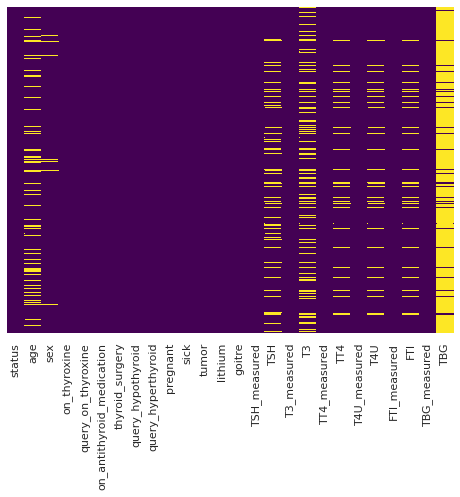

In [ ]:

plt.figure(figsize=(8,6))
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [ ]:
pd.DataFrame({"Missing Values(%)":
              data.isna().sum()/len(data.index)*100})

,Missing Values(%)
status,0.000000
age,14.100537
sex,2.307936
on_thyroxine,0.000000
query_on_thyroxine,0.000000
on_antithyroid_medication,0.000000
thyroid_surgery,0.000000
query_hypothyroid,0.000000
query_hyperthyroid,0.000000
pregnant,0.000000


##1.5 Data Types

In [ ]:
#we have to change formats of some of our 
#columns since all of them are of object data type

pd.DataFrame({'Data Types': data.dtypes})

,Data Types
status,object
age,object
sex,object
on_thyroxine,object
query_on_thyroxine,object
on_antithyroid_medication,object
thyroid_surgery,object
query_hypothyroid,object
query_hyperthyroid,object
pregnant,object


##1.6 Change Data Types

In [ ]:
# we will delete TBG since 91%  ofthe data hasa anomalies
data = data.drop(columns=['TBG'])

#we will replace with the mean in column T4U since 7% has anomalies

data['T4U'].replace([np.nan], data['T4U'].mean(), inplace=True )

#we will replace with the mean in column TT4 since 7% has anomalies
data['TT4'].replace([np.nan], data['TT4'].mean(), inplace=True)

#we will replace with the mean in column FTI since 7% has anomalies
data['FTI'].replace([np.nan], data['FTI'].mean(), inplace=True )

# we will replace with mean in TSH
data['TSH'].replace([np.nan], data['T4U'].mean(), inplace=True)

data['T3'].replace([np.nan], data['T3'].mean(), inplace=True)

##1.7 Descriptive Statistical


In [ ]:
# divide into numerical and categorical columns, as they will be treated with different techniques.
num_attributes = data.select_dtypes( include=['float64'] )
cat_attributes = data.select_dtypes( exclude=['float64', 'datetime64[ns]'] )

In [ ]:
num_attributes.sample()

,TSH,T3,TT4,T4U,FTI
3089,0.978199,1.939749,87.0,0.85,102.0


In [ ]:
cat_attributes.sample()

,status,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,thyroid_surgery,query_hypothyroid,query_hyperthyroid,pregnant,sick,tumor,lithium,goitre,TSH_measured,T3_measured,TT4_measured,T4U_measured,FTI_measured,TBG_measured
2242,negative,NaN,F,f,f,f,f,f,f,f,f,f,f,f,y,y,y,y,y,n


##1.7.1 Numerical Attributes


In [ ]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T
d7 = pd.DataFrame( num_attributes.apply( lambda x: x.var() ) ).T
# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6, d7] ).T.reset_index()
m.columns = ( ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis', 'Variance'])

In [ ]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis,Variance
0,TSH,0.0,530.00,530.00,5.191517,0.978199,22.126314,11.068470,179.258139,489.728596
1,T3,0.0,10.20,10.20,1.939749,1.939749,0.880301,2.401958,14.017703,0.775176
2,TT4,2.0,450.00,448.00,108.850000,107.000000,43.650864,1.571505,7.810266,1906.000495
3,T4U,0.0,2.21,2.21,0.978199,0.978199,0.217478,0.954853,3.963176,0.047312
4,FTI,0.0,881.00,881.00,115.397771,110.000000,57.829783,5.317936,51.464046,3345.341428


## 1.7.2 Categorical Attributes

In [ ]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

status                        2
age                          93
sex                           3
on_thyroxine                  2
query_on_thyroxine            2
on_antithyroid_medication     2
thyroid_surgery               2
query_hypothyroid             2
query_hyperthyroid            2
pregnant                      2
sick                          2
tumor                         2
lithium                       2
goitre                        2
TSH_measured                  2
T3_measured                   2
TT4_measured                  2
T4U_measured                  2
FTI_measured                  2
TBG_measured                  2
dtype: int64

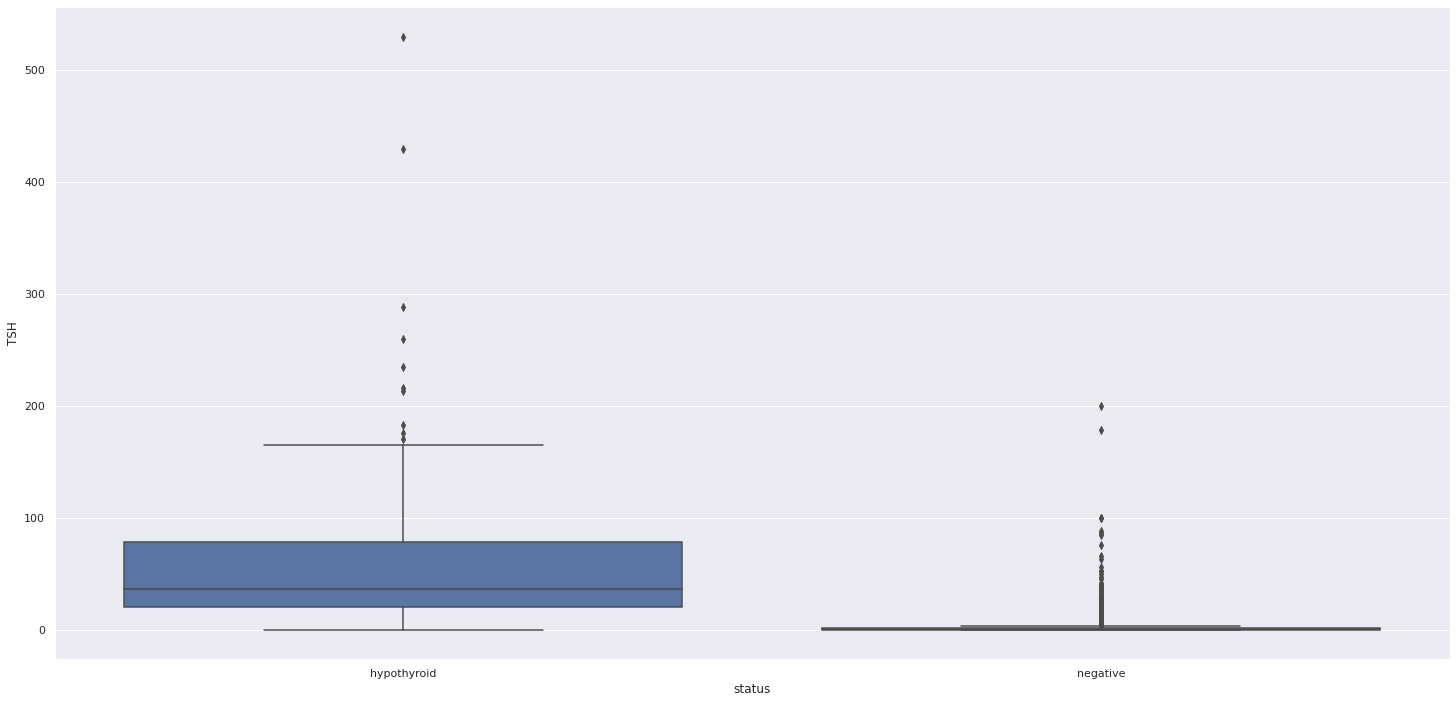

In [ ]:
sns.boxplot( x= 'status', y='TSH' , data=data )

#2.0 FEATURE ENGINEERING

In [ ]:
df1 = data.copy()

In [ ]:
Image("Hypothyroid.png")

#2.1 Creation of Hypotheses

##2.1.1 Hormonal Hypotheses

1.High TSH levels can mean your thyroid is not making enough thyroid hormones, a condition called hypothyroidism.


2.Low TSH levels can mean your thyroid is making too much of the hormones, a condition called hyperthyroidism.
 

3.Low T4 levels can mean your thyroid is making too much of the hormones, a condition called hypothyroidism.


4.High T4 levels can mean your thyroid is not making enough thyroid hormones, a condition called hypothyroidism.



##2.1.2 Demographic Factors


1.   Females have a higher thyroid potential  than men

2.   Persons above 65 have higher chance of getting hypothyroid




## 2.1.3 Symptomatic Factors


1.   Pregnant women have a higher chance of being diagnosed hypothyroid

2.   Goiter may be associated with an irregular amount of thyroid hormone in your body 

3.  A tumor may be associated with hypothyroid

4. Lithium use is associated with an increased risk of hypothyroidism.

# 3.0 EXPLORATORY DATA ANALYSIS

## 3.1 Univariate Analysis


### 3.1.1 Response Variable

In [ ]:

def plot_stacked_bars(dataframe, title_, size_=(18, 10), rot_=0, legend_="upper right"):

  """
  Plot stacked bars with annotations
  """
  ax = dataframe.plot(kind="bar",
                    stacked=True,
                    figsize=size_,
                    rot=rot_,
                    title=title_)
  # Annotate bars
  annotate_stacked_bars(ax, textsize=14)
  # Rename legend
  plt.legend(["Hypothyroid", "Negative"], loc=legend_)
  # Labels
  plt.ylabel("Diagnosis base (%)")
  plt.show()

def annotate_stacked_bars(ax, pad=0.99, colour="white", textsize=13):
  """
  Add value annotations to the bars
  """
  # Iterate over the plotted rectanges/bars
  for p in ax.patches:
    # Calculate annotation
    value = str(round(p.get_height(),1))
    # If value is 0 do not annotate
    if value == '0.0':
     continue
    ax.annotate(value,
                ((p.get_x()+ p.get_width()/2)*pad-0.05, (p.get_y()+p.get_height()/2)*pad),
                color=colour,
                size=textsize,)

In [ ]:
df1['id'] = range(1, len(df1) + 1)
diagnosis = df1[['id', "status"]]

In [ ]:
diagnosis.sample()

,id,status
1587,1588,negative


In [ ]:
diagnosis_total = diagnosis.groupby(diagnosis['status']).count()
diagnosis_percent = diagnosis_total / diagnosis_total.sum() *100

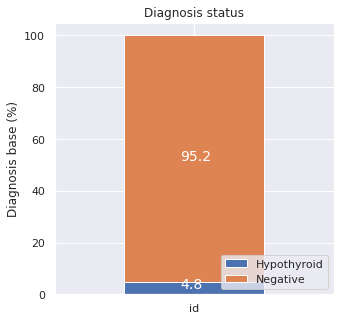

In [ ]:
plot_stacked_bars(diagnosis_percent.transpose(),"Diagnosis status", (5,5), legend_="lower right")

95.2 percent of patients dont have hypothyroid.
4.8 percent of patients have Hypothyroid

Text(0.5, 1.0, 'Diagnosis Status')

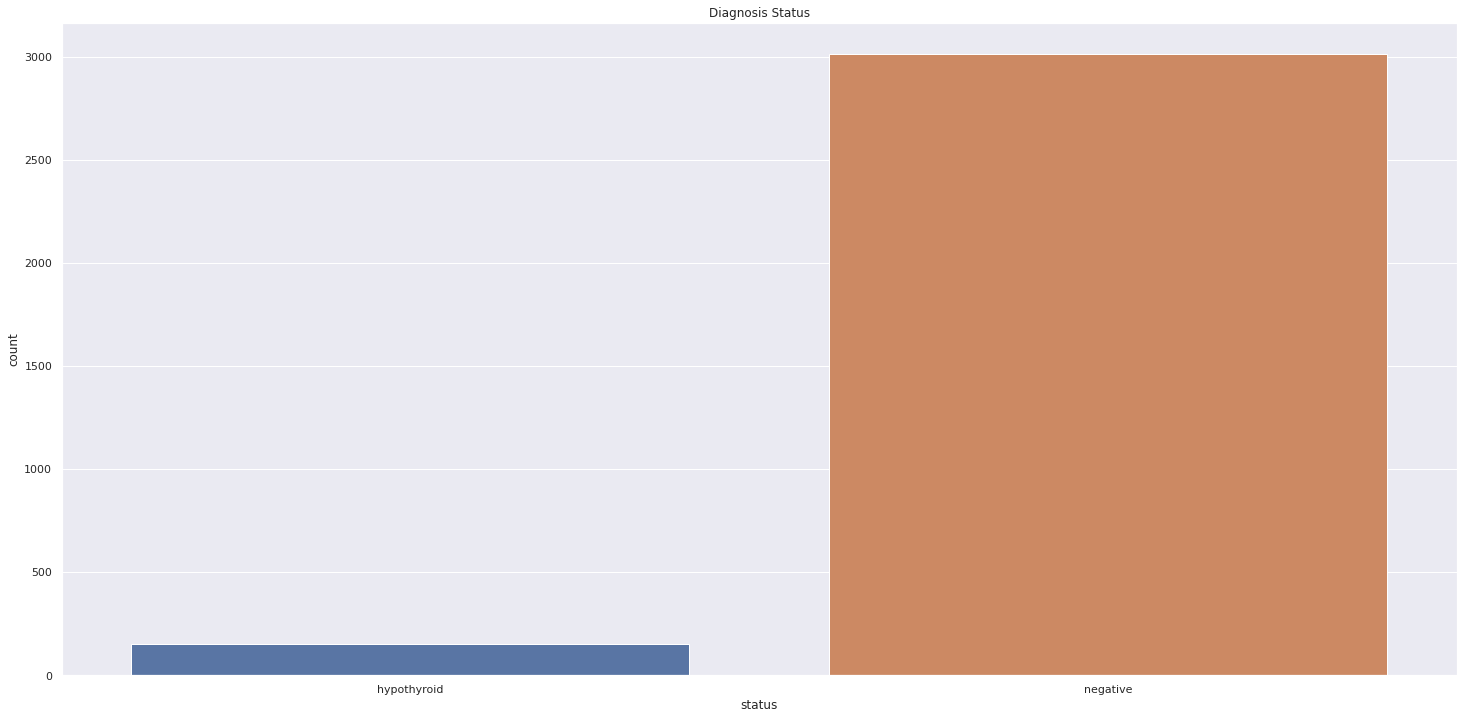

In [ ]:
sns.countplot(df1['status'])
plt.title("Diagnosis Status")

### 3.1.2 Numerical Variables

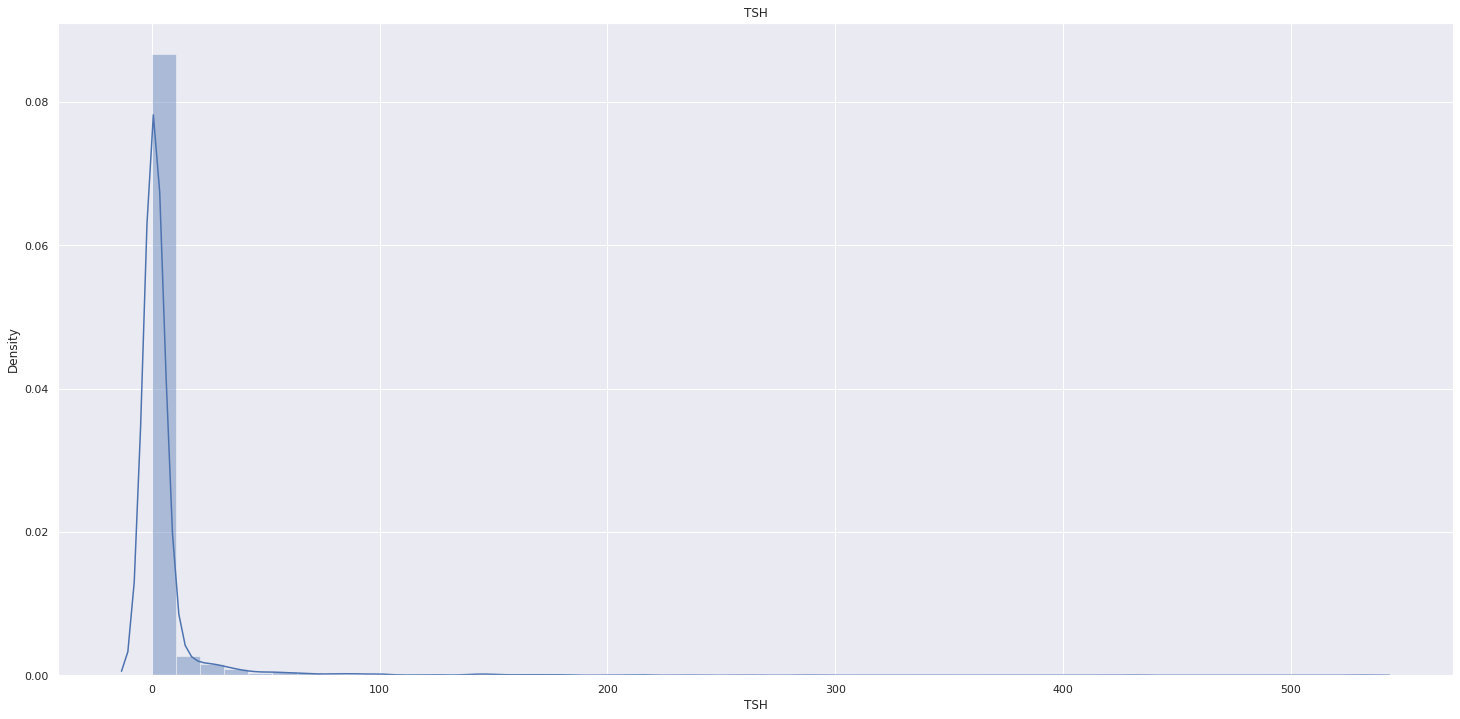

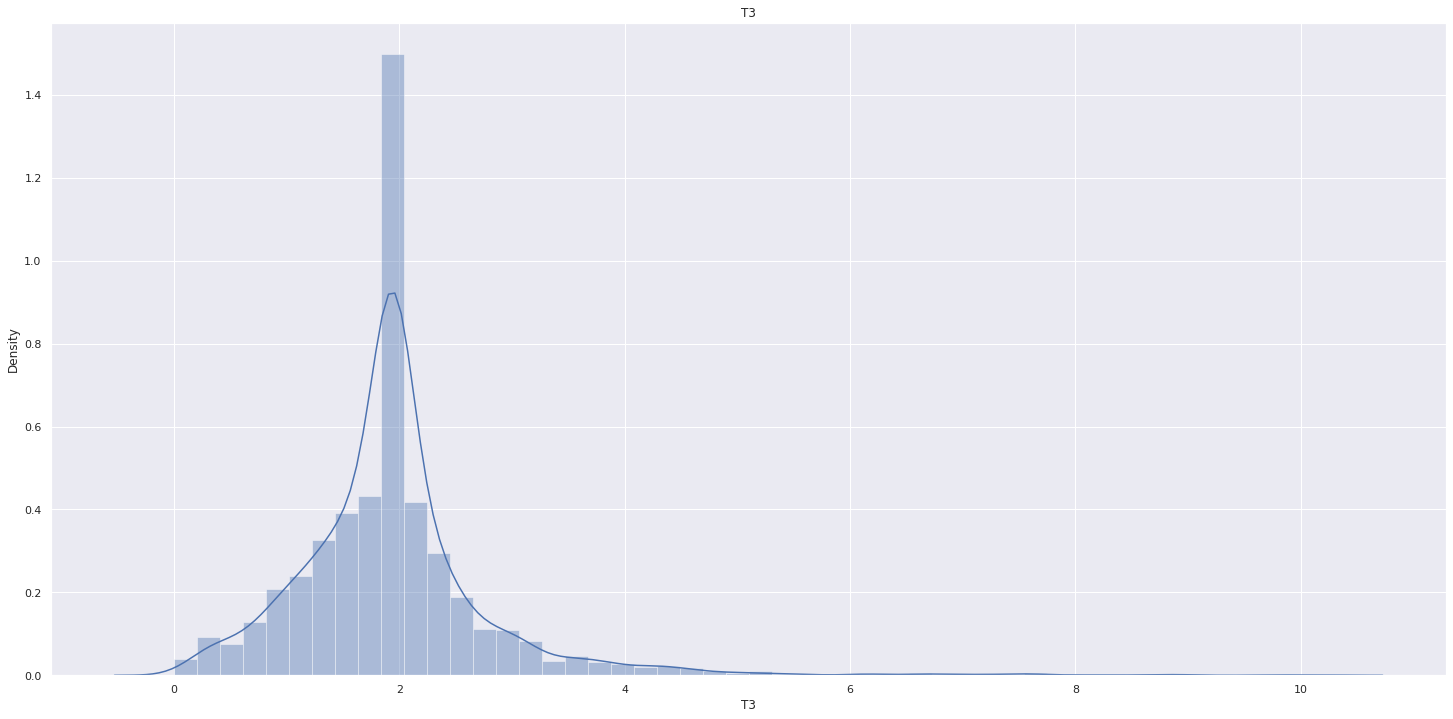

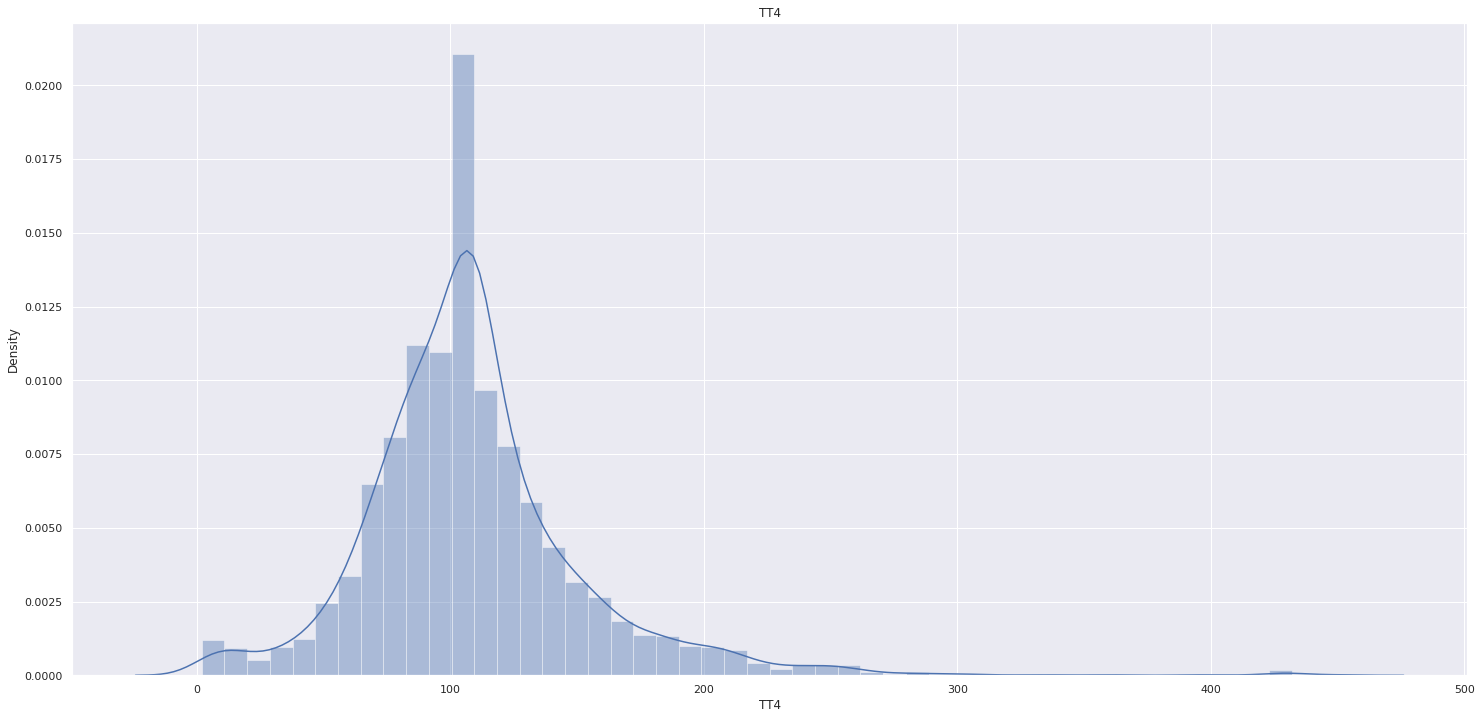

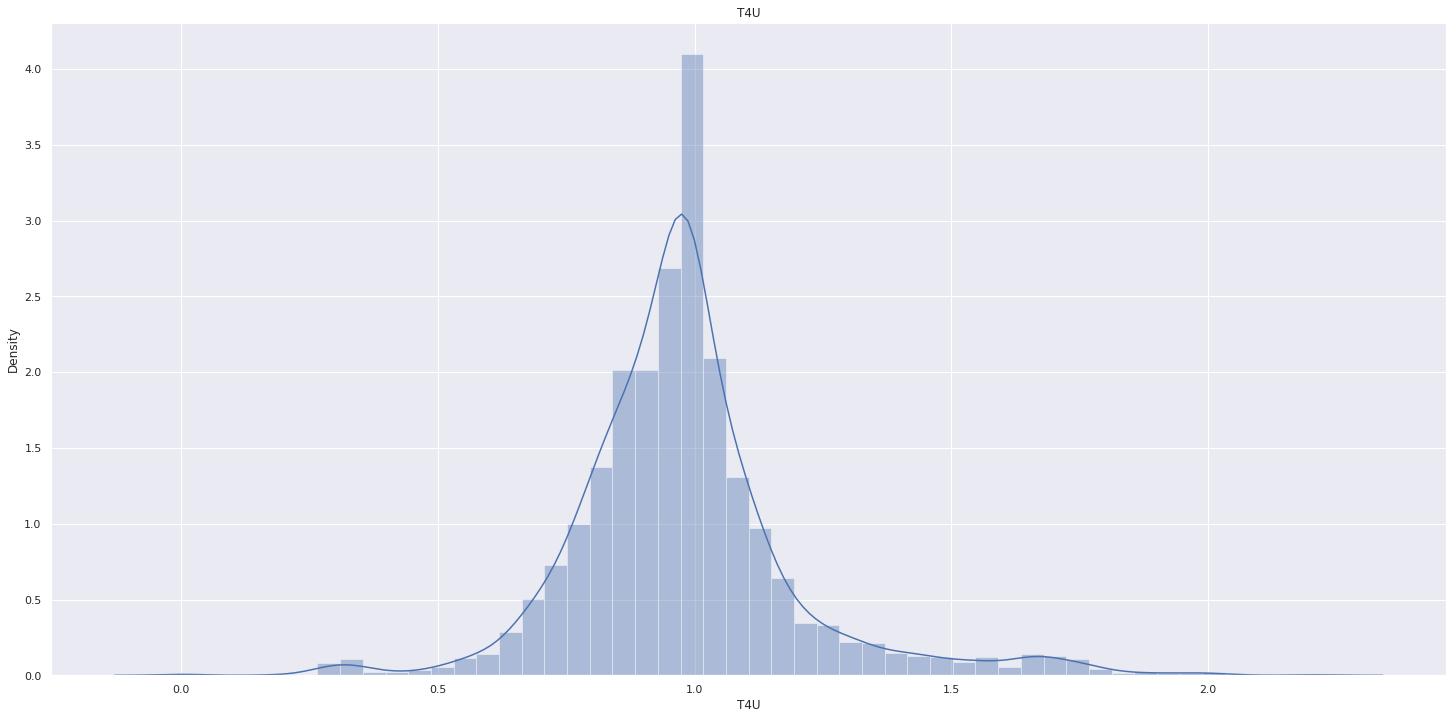

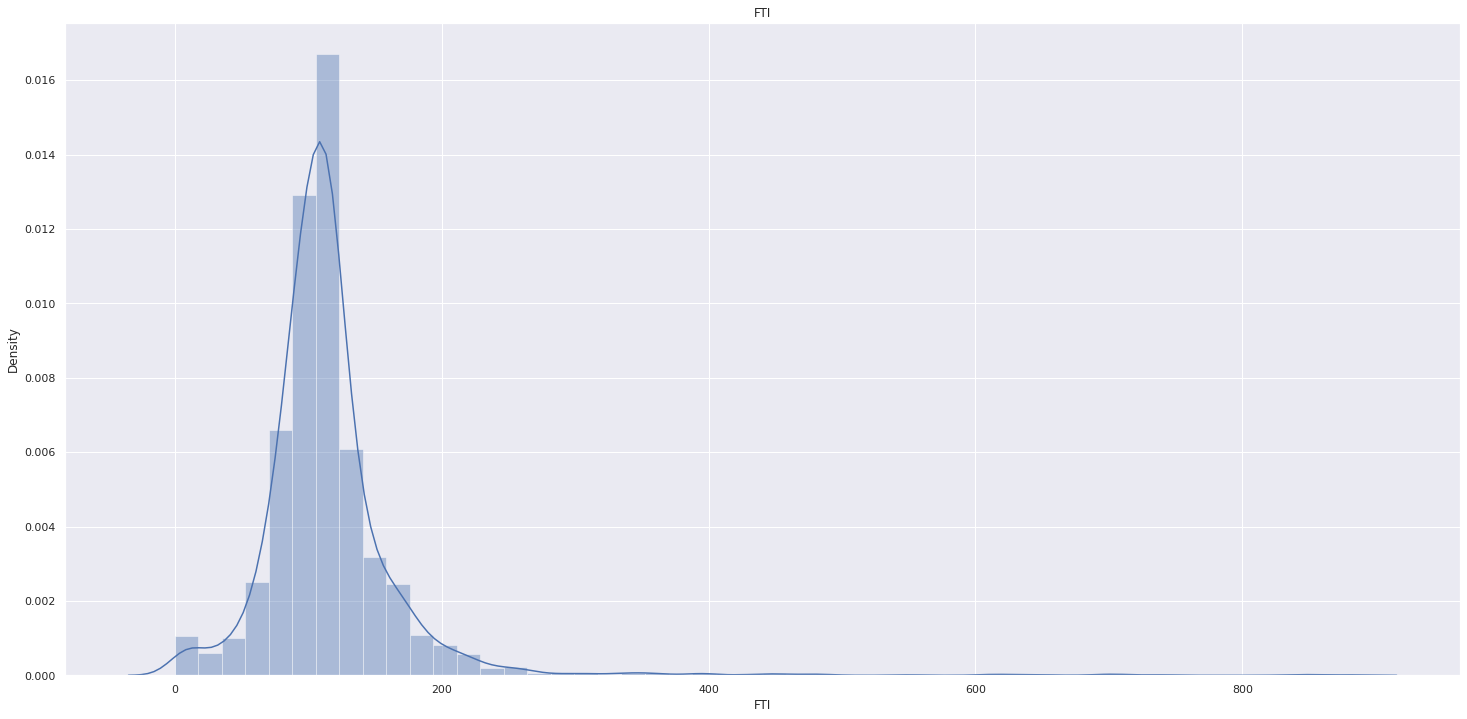

In [ ]:
for n in num_attributes[0:5]:
  sns.distplot(num_attributes[n], kde=True)
  plt.title((n))
  plt.show()


### 3.1.3 Categorical Attributes

In [ ]:
cat_attributes.sample()

,status,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,thyroid_surgery,query_hypothyroid,query_hyperthyroid,pregnant,sick,tumor,lithium,goitre,TSH_measured,T3_measured,TT4_measured,T4U_measured,FTI_measured,TBG_measured
1459,negative,52,M,f,f,f,f,f,f,f,f,f,f,f,n,n,y,y,y,n


In [ ]:
cat_attributes.columns

Index(['status', 'age', 'sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_medication', 'thyroid_surgery', 'query_hypothyroid',
       'query_hyperthyroid', 'pregnant', 'sick', 'tumor', 'lithium', 'goitre',
       'TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured',
       'FTI_measured', 'TBG_measured'],
      dtype='object')

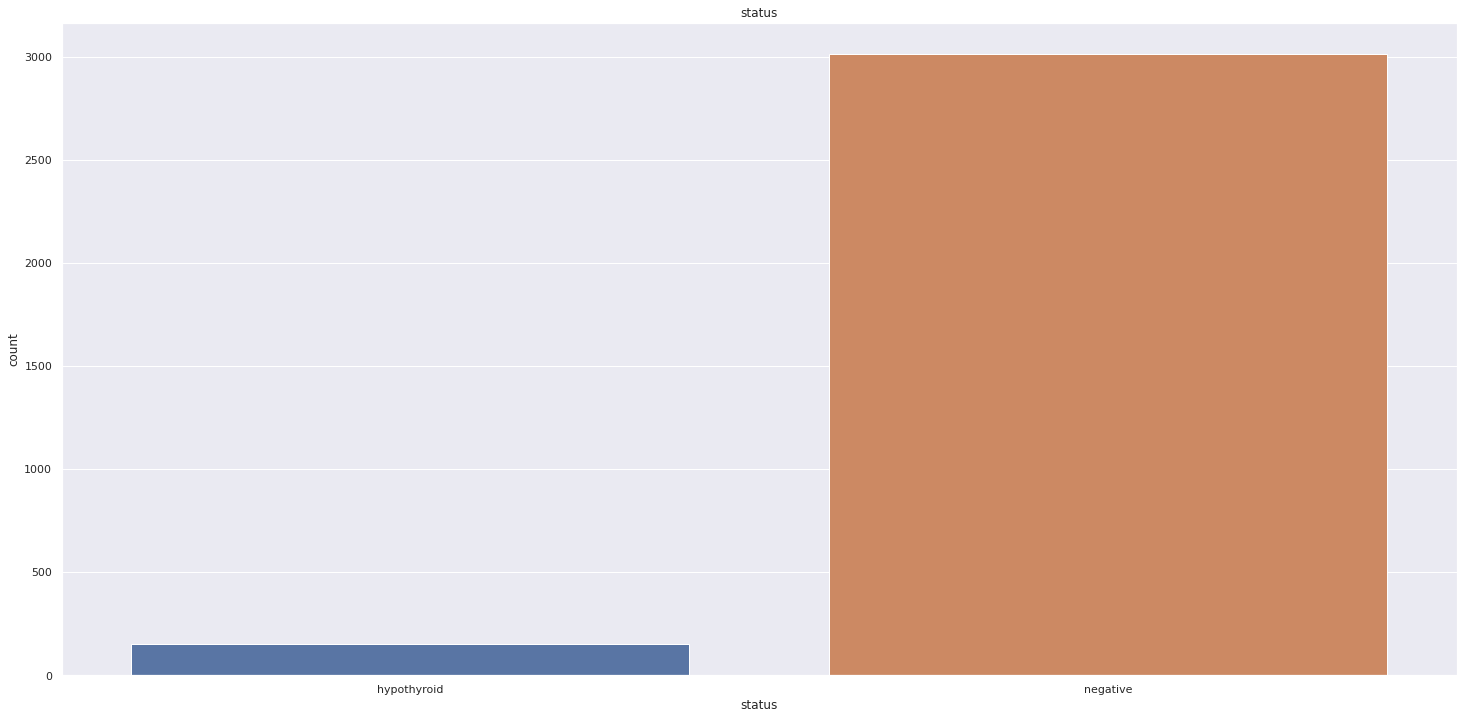

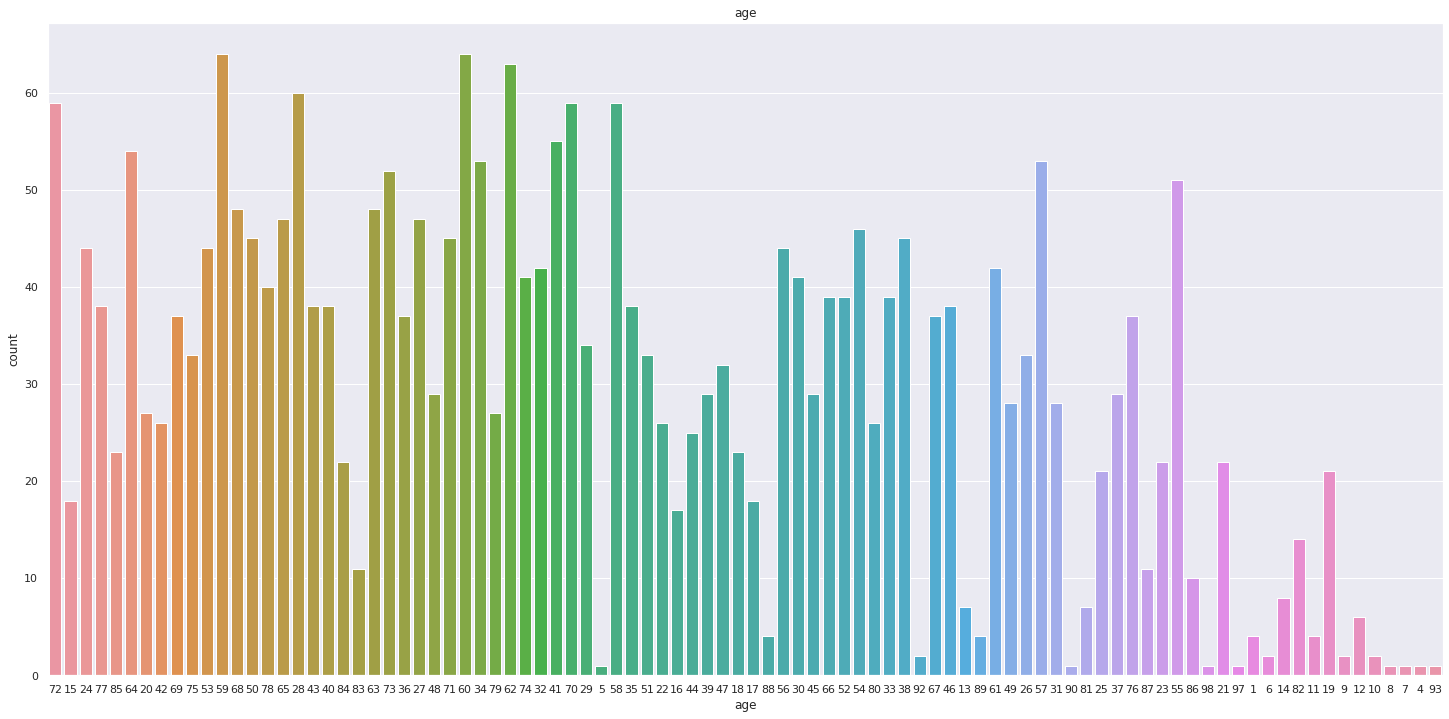

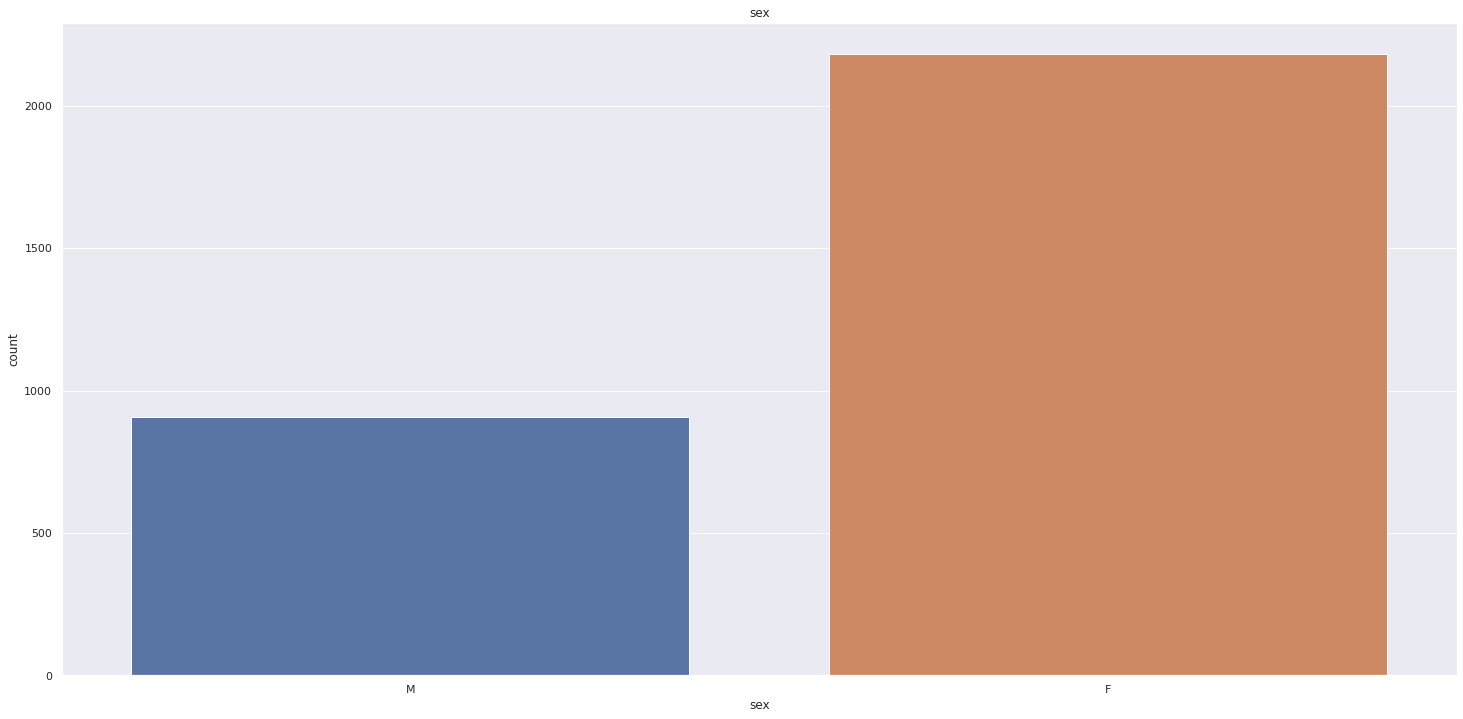

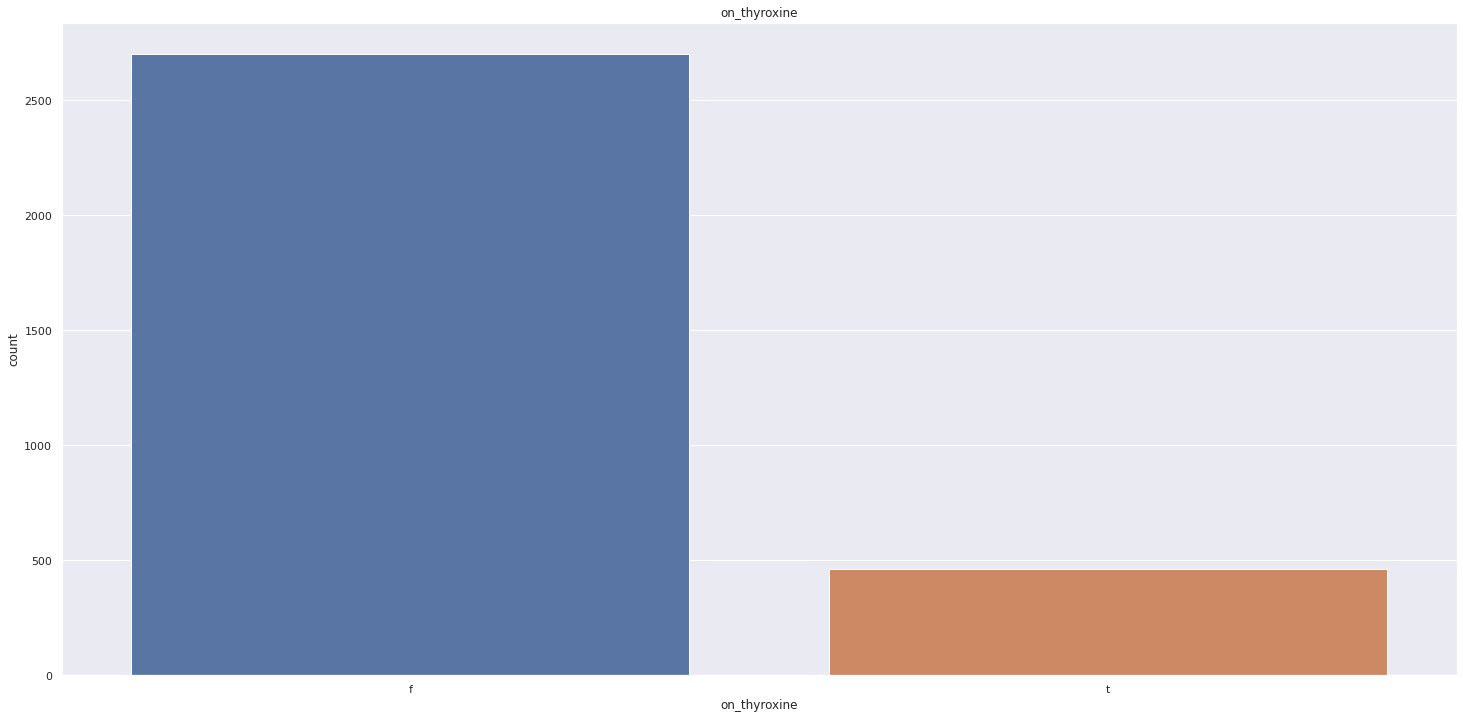

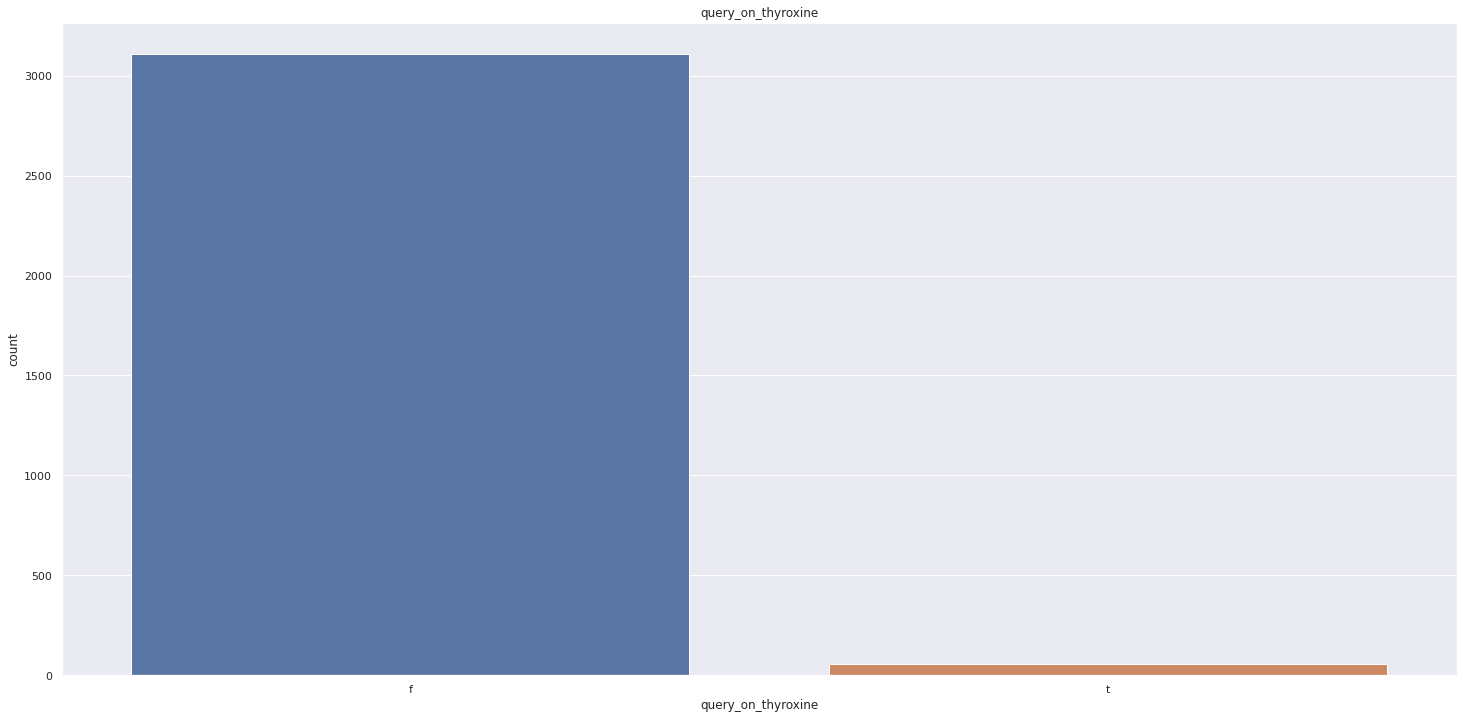

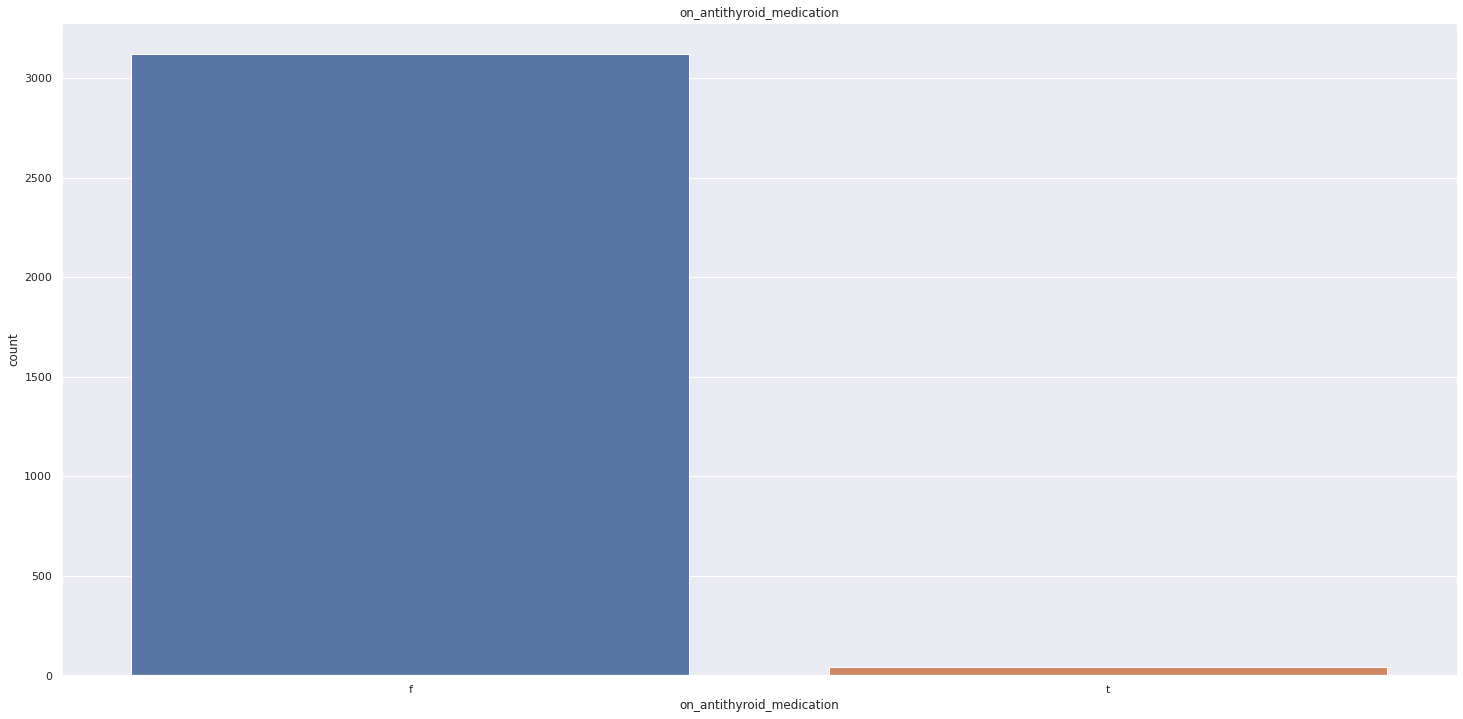

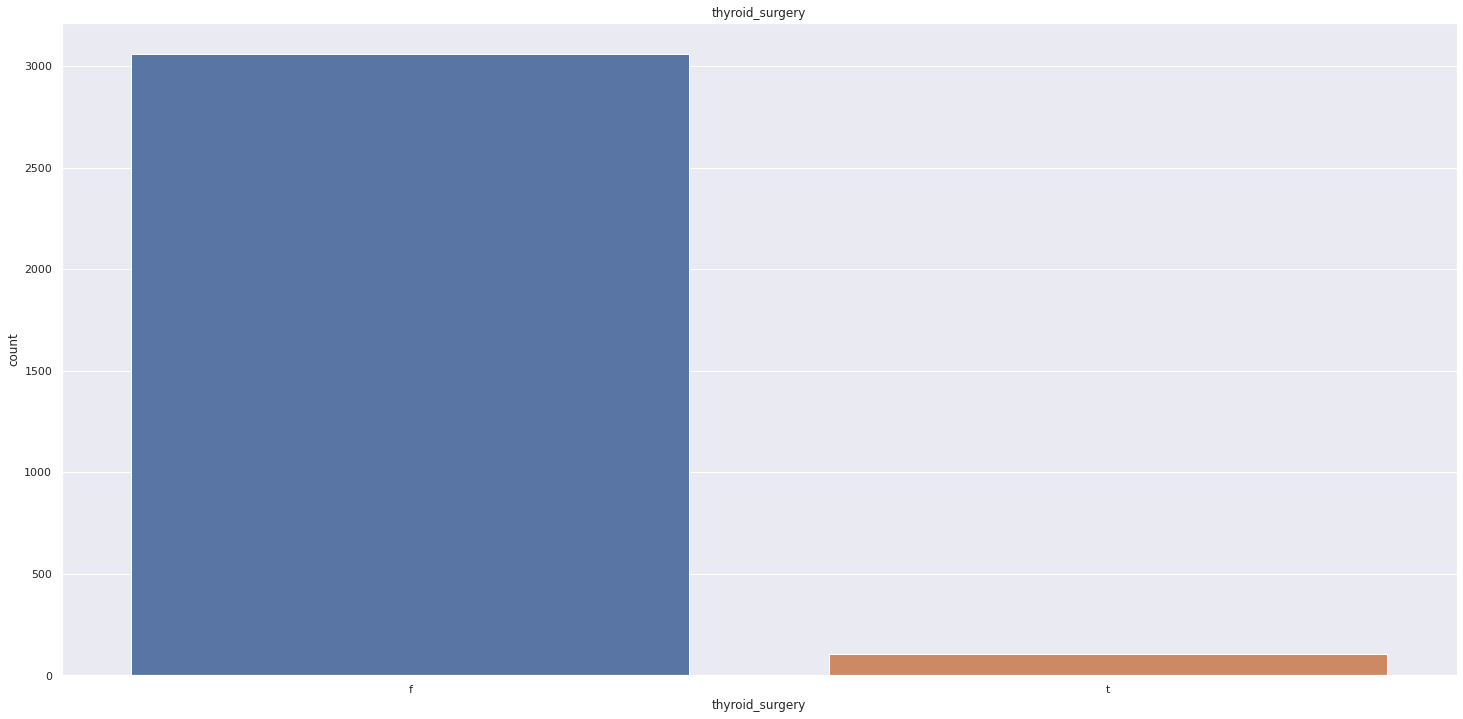

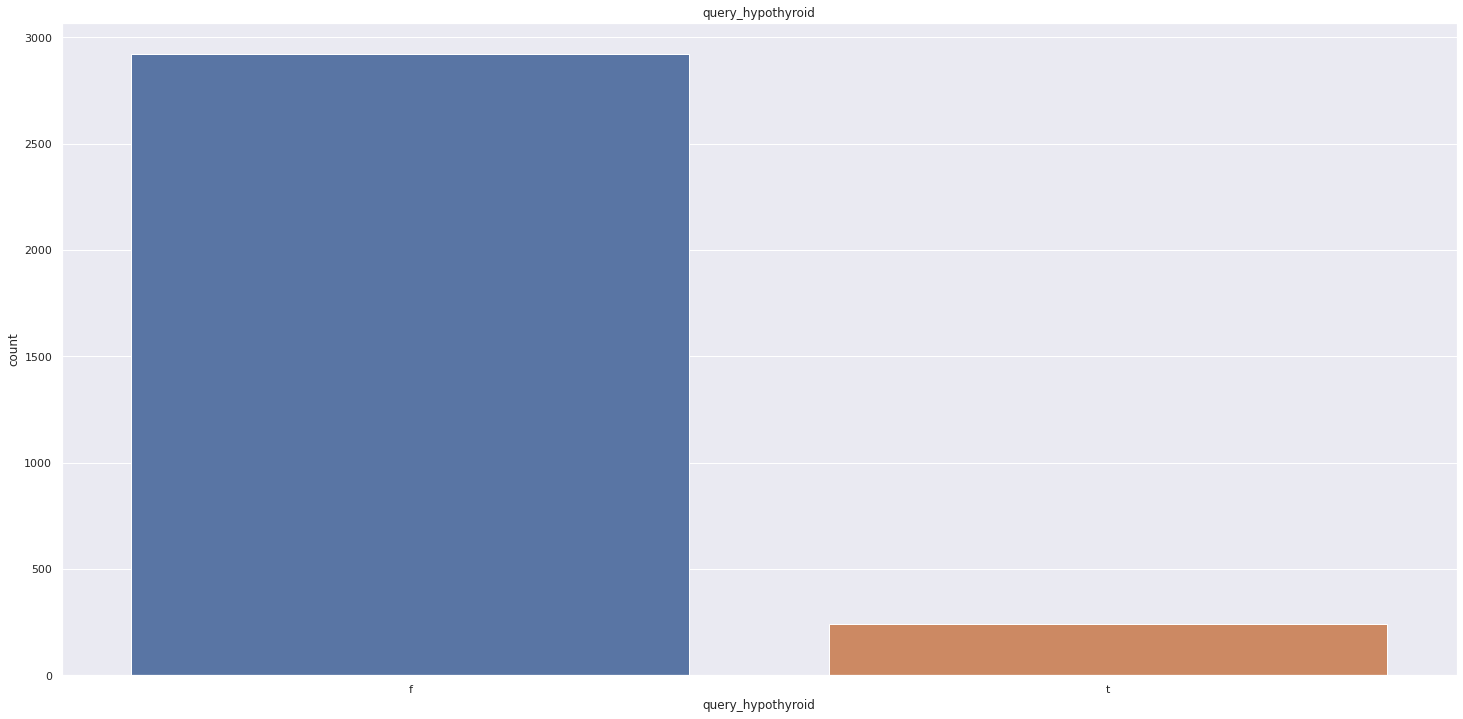

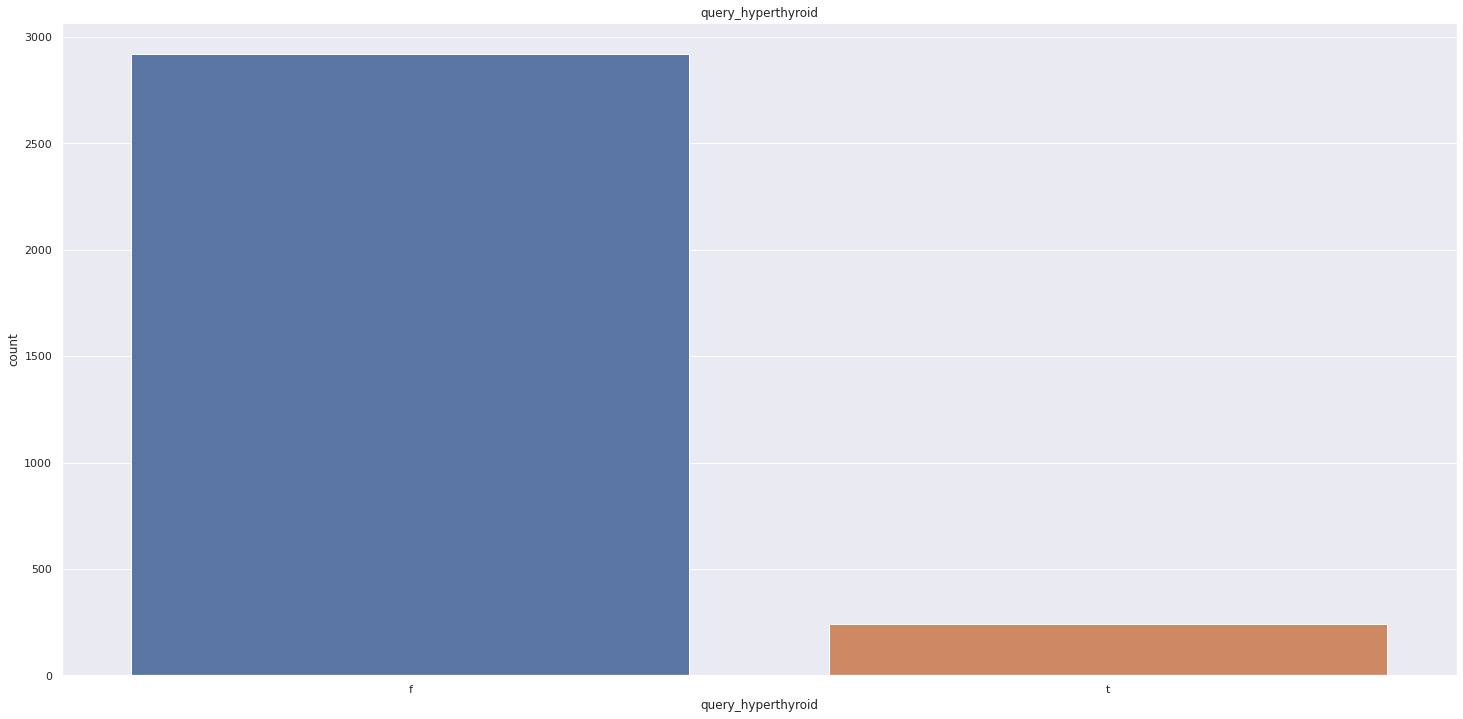

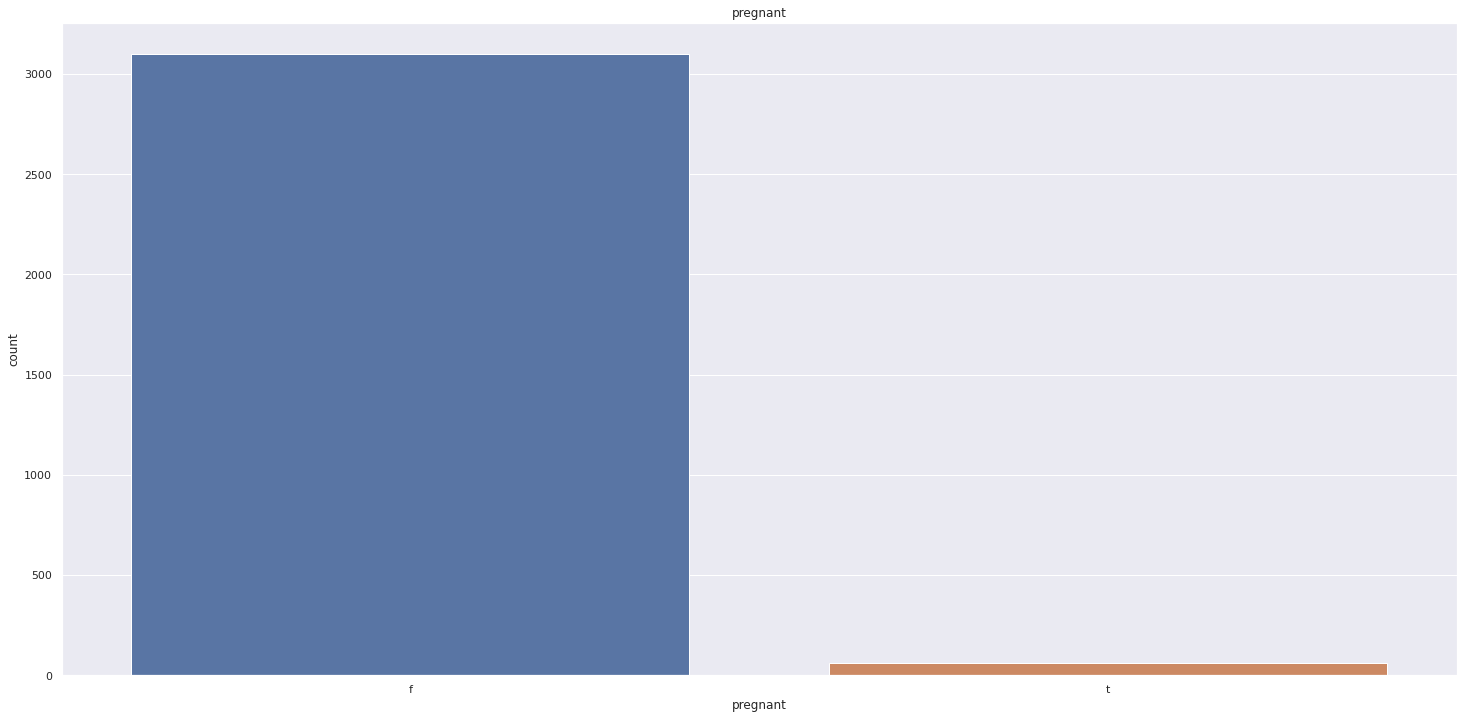

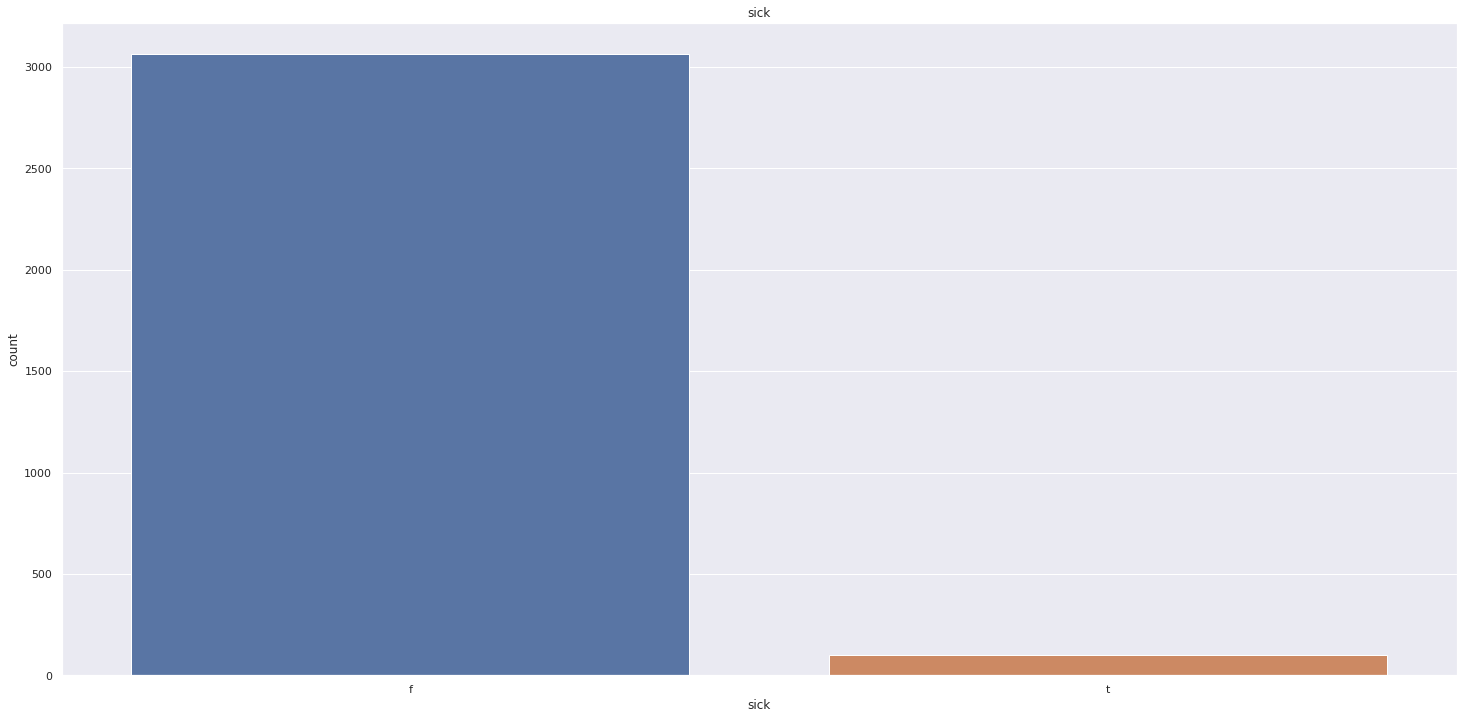

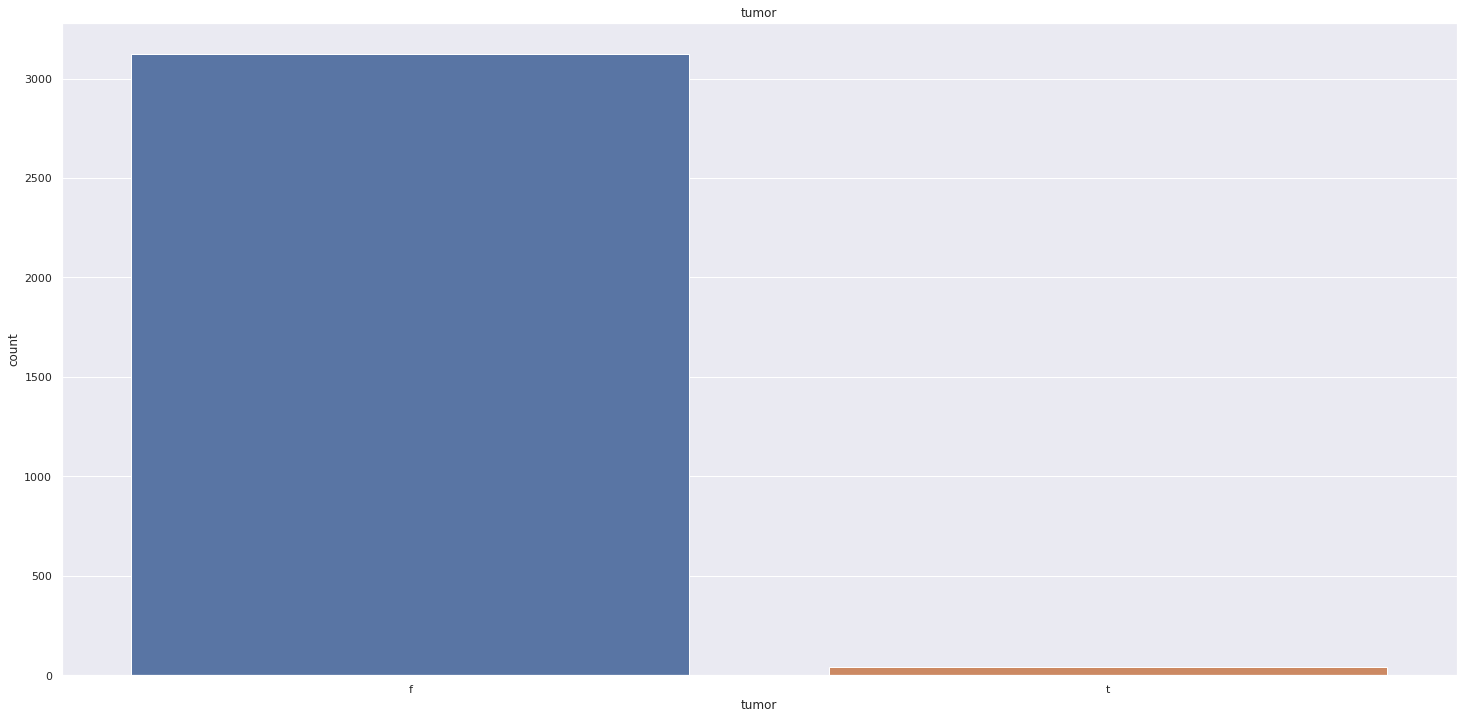

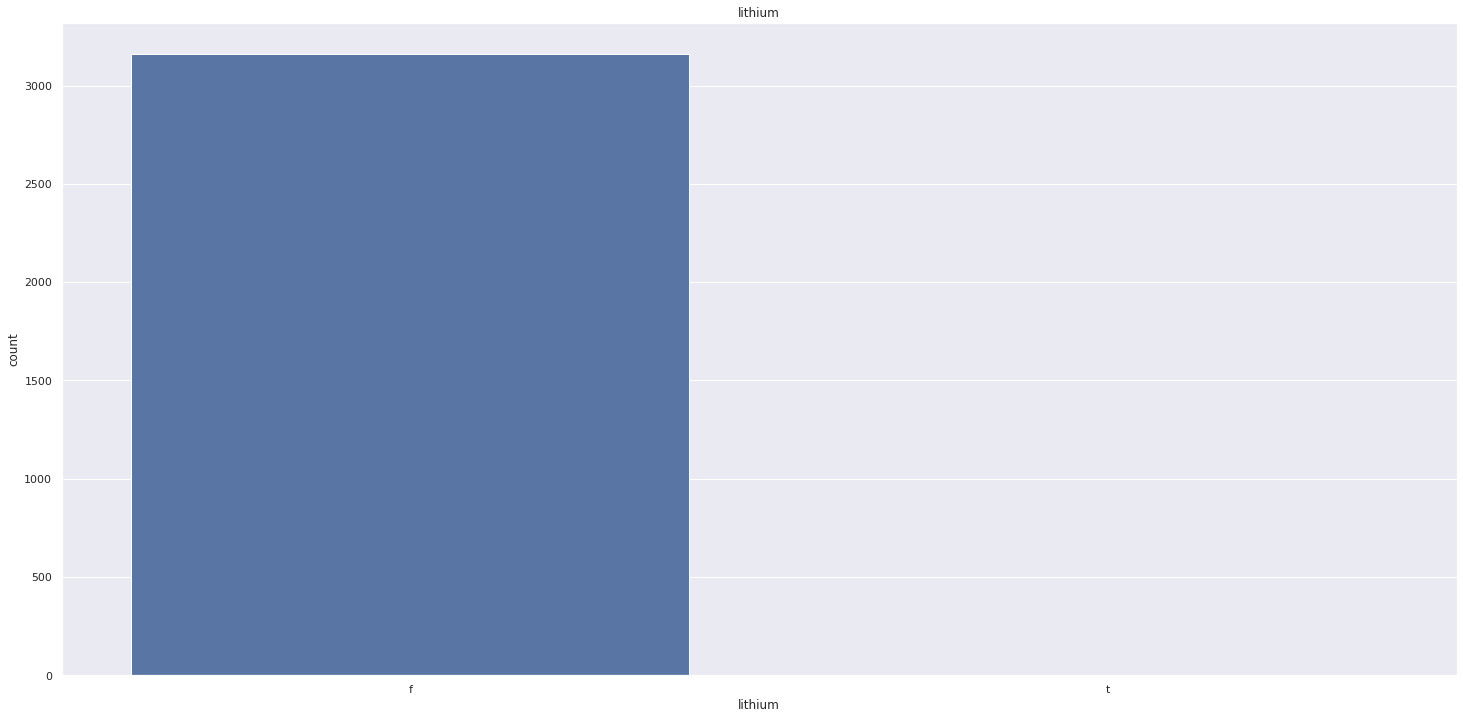

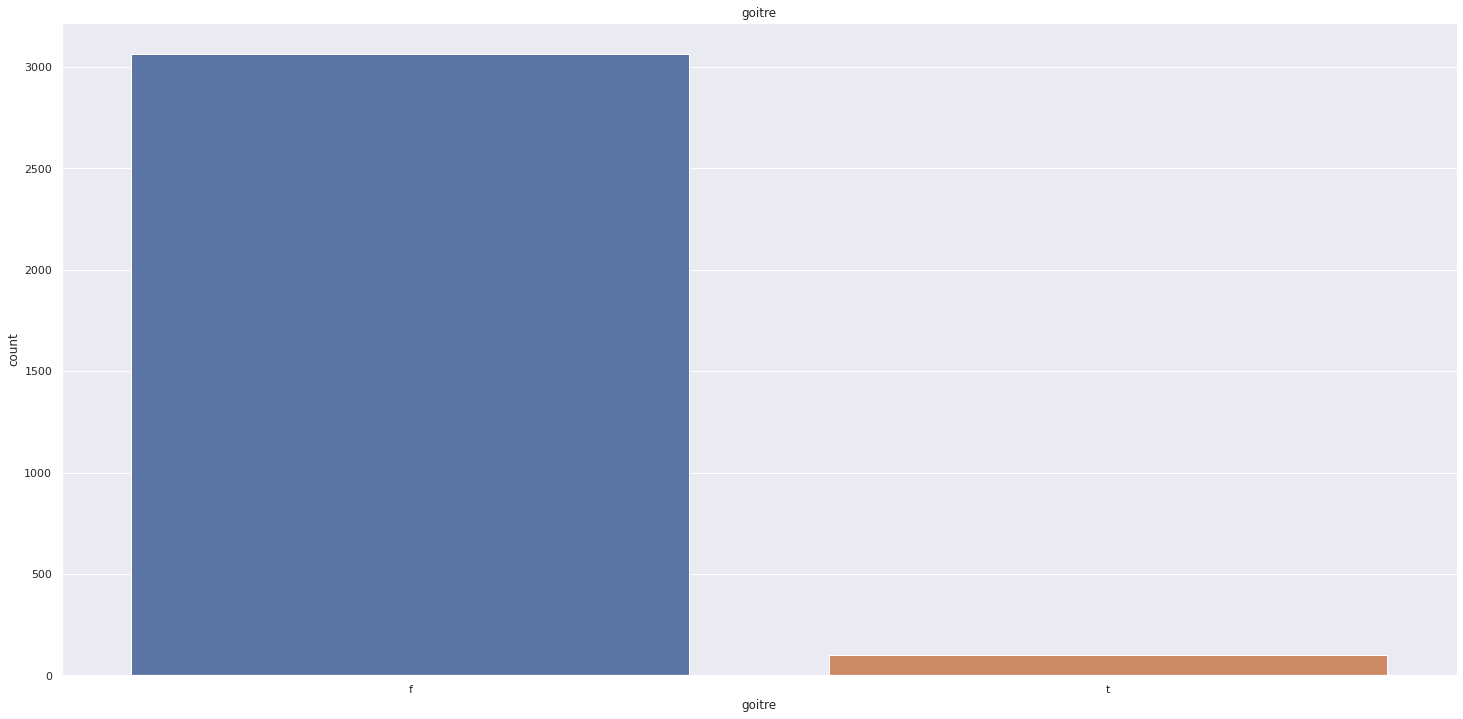

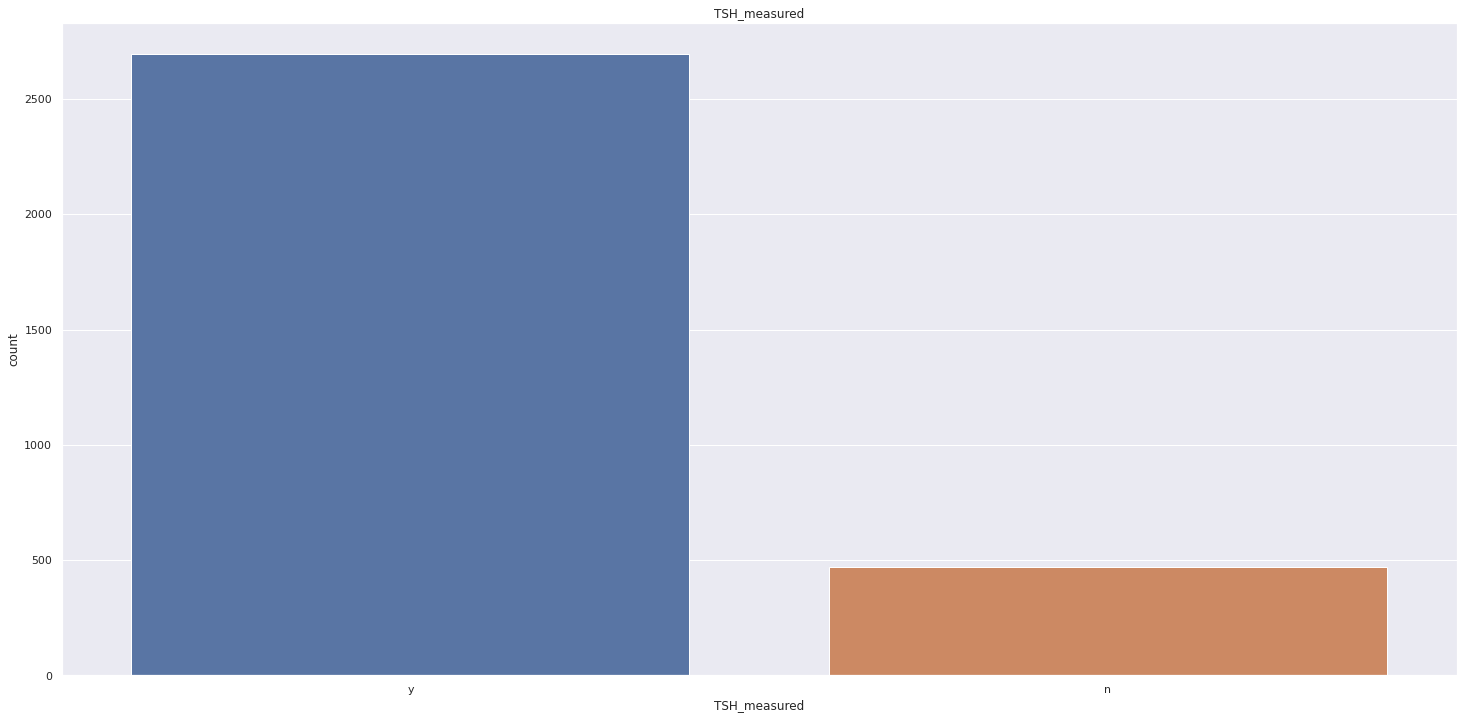

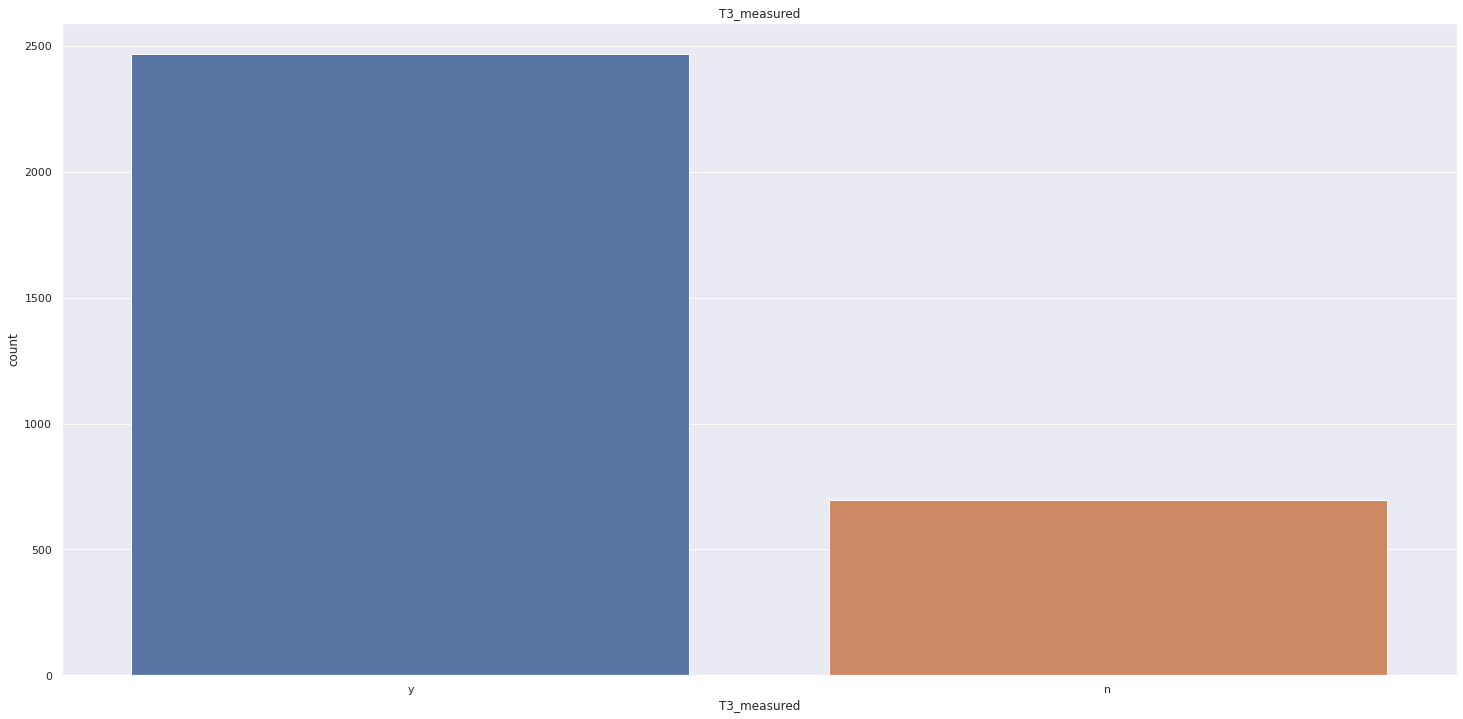

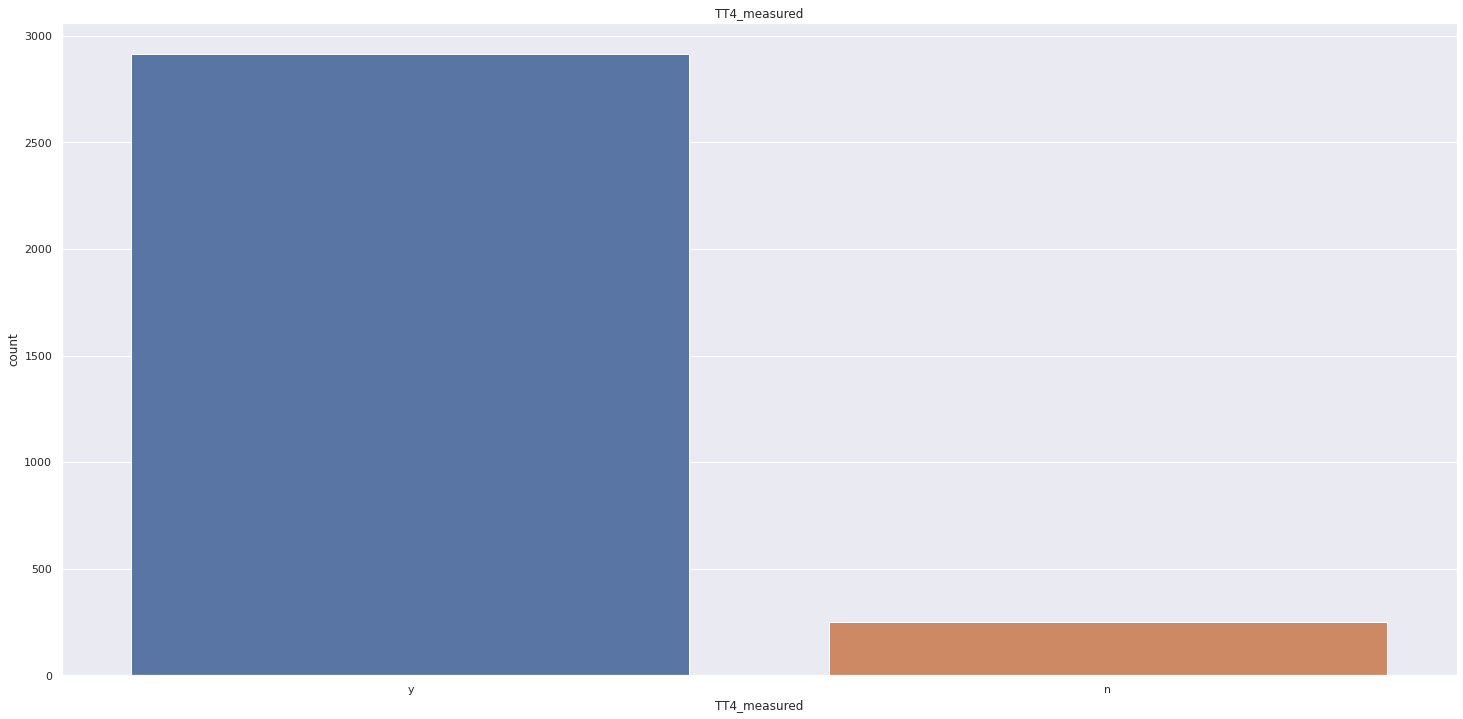

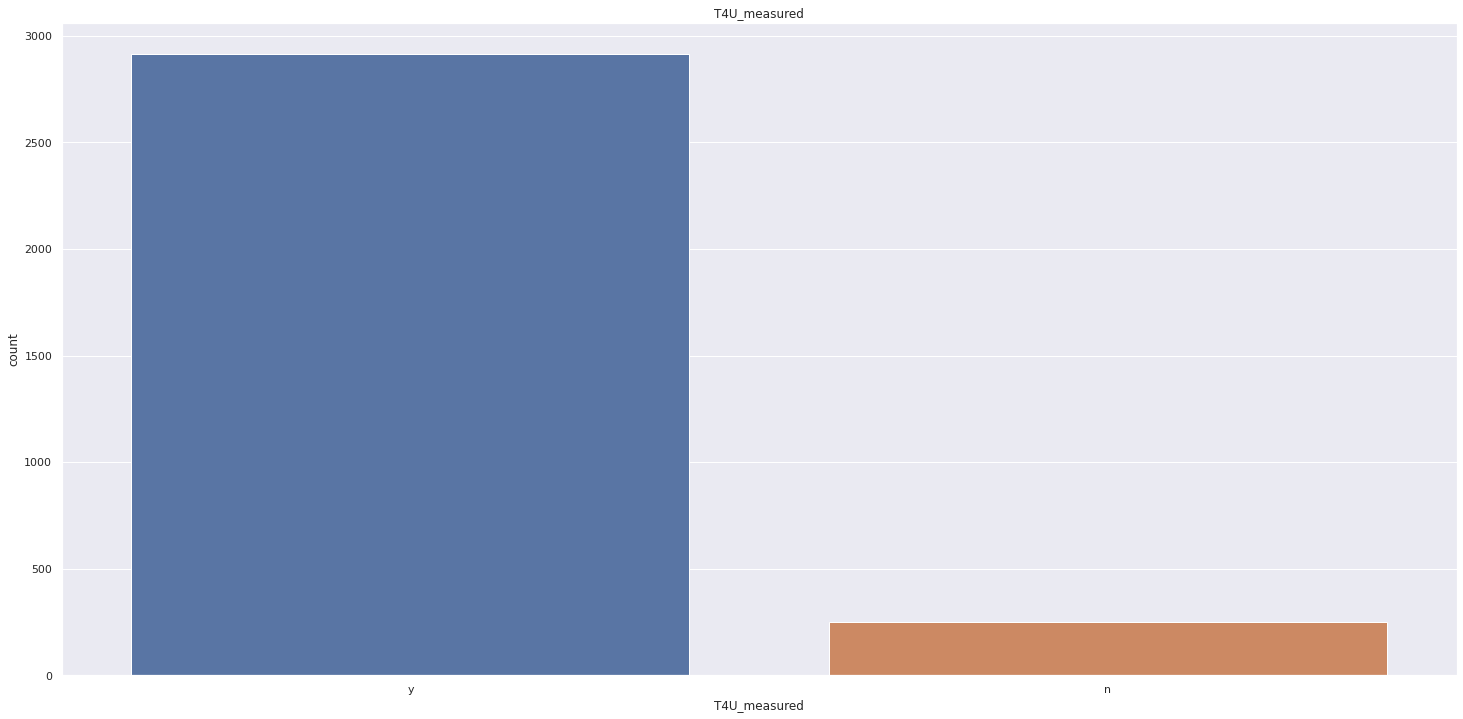

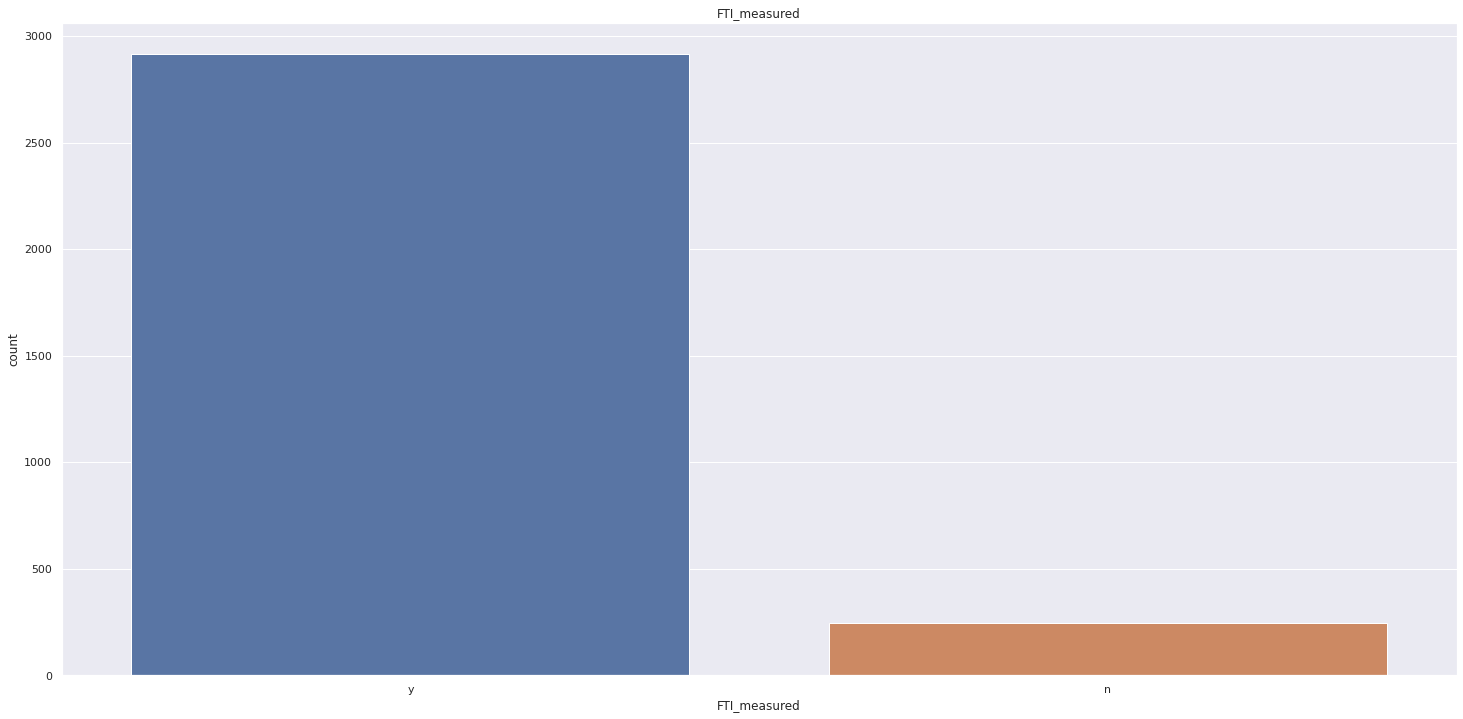

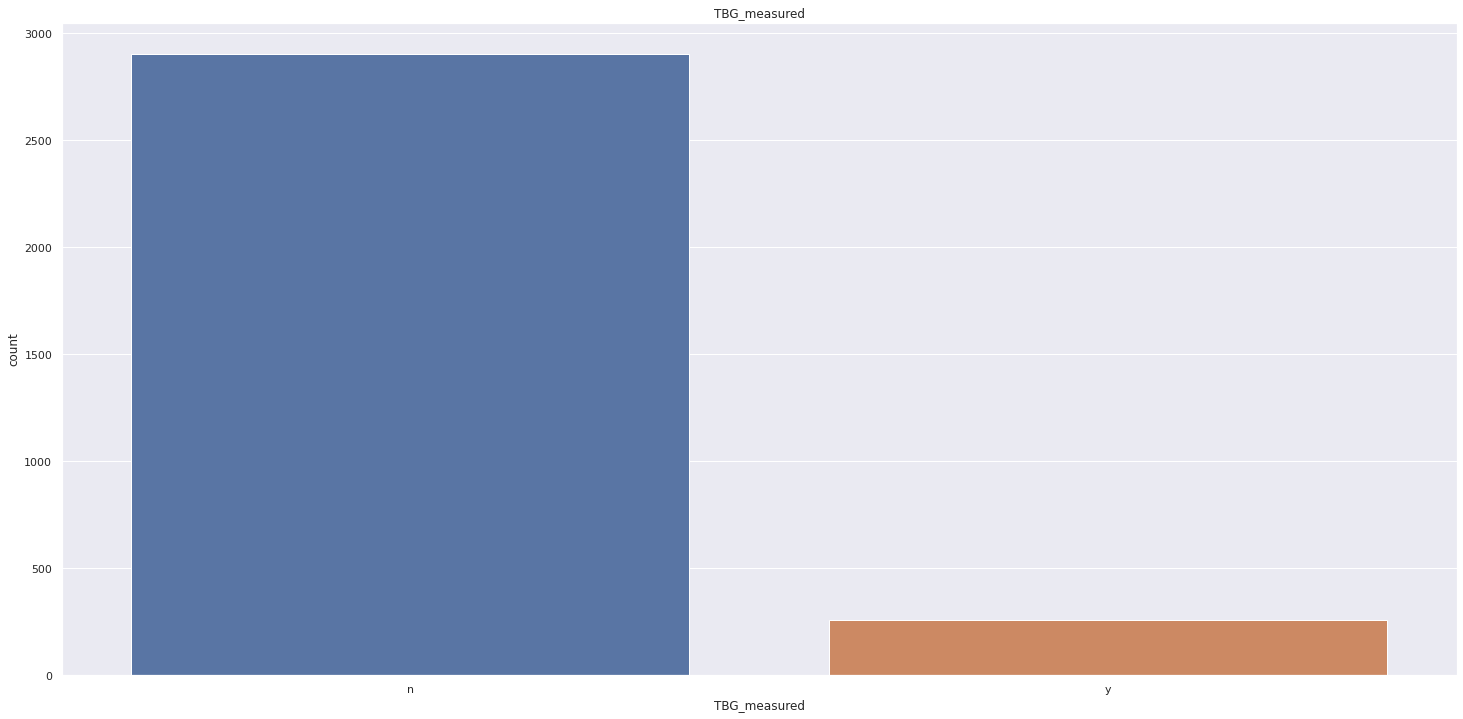

In [ ]:
for c in cat_attributes[0:21]:
  splot = sns.countplot(cat_attributes[c])
  plt.title((c))
  plt.show()



##3.2 Bivariate Analysis

In [ ]:
df1.sample()

,status,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,thyroid_surgery,query_hypothyroid,query_hyperthyroid,pregnant,sick,tumor,lithium,goitre,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,id
161,negative,45,F,t,f,f,t,f,f,f,f,f,f,f,y,0.0,y,2.3,y,206.0,y,1.05,y,196.0,n,162


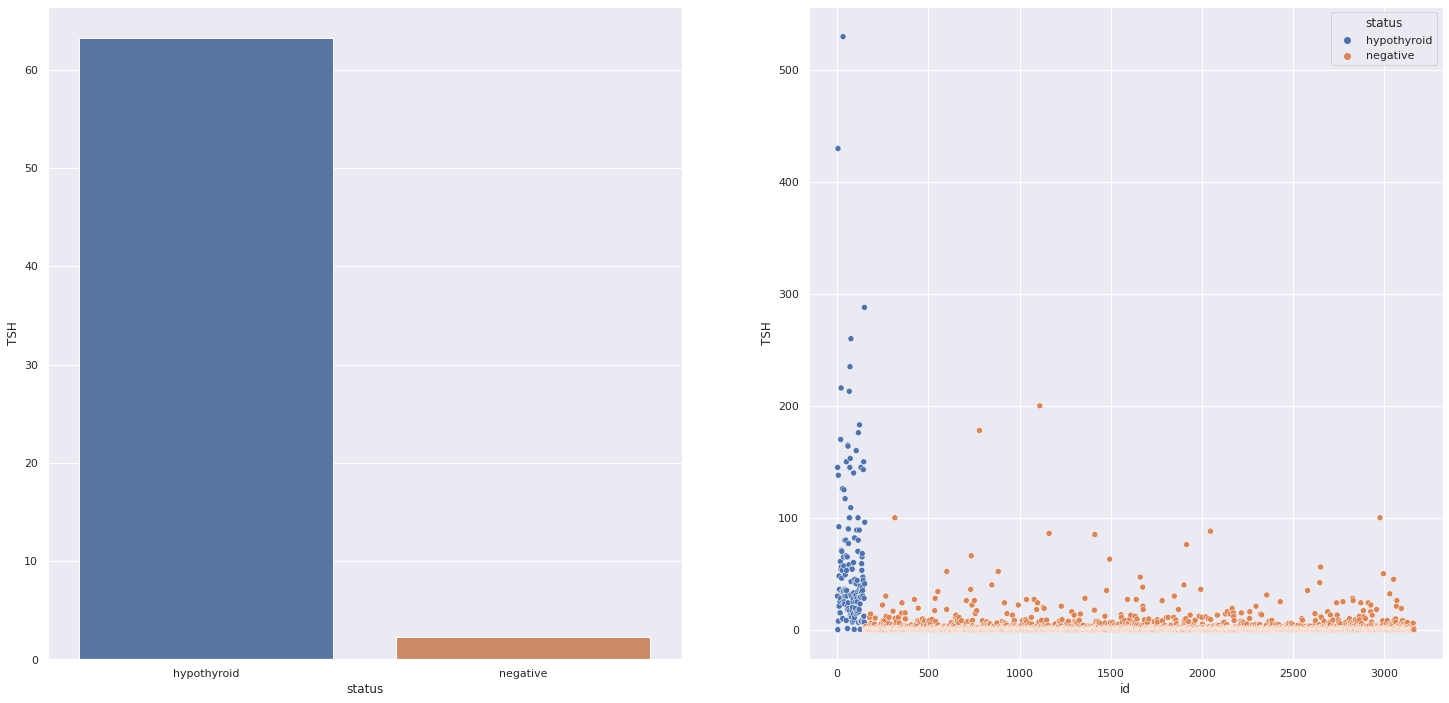

In [ ]:

# Hypothyroid case have significantly high TSH levels
aux1 = df1[['status', 'TSH']].groupby( 'status' ).sum().reset_index()
plt.subplot(1,2,1)
sns.barplot( x='status', y='TSH', data=df1, ci=None)
plt.step

plt.subplot(1,2,2)
sns.scatterplot(data=df1, x="id", y="TSH", hue="status")


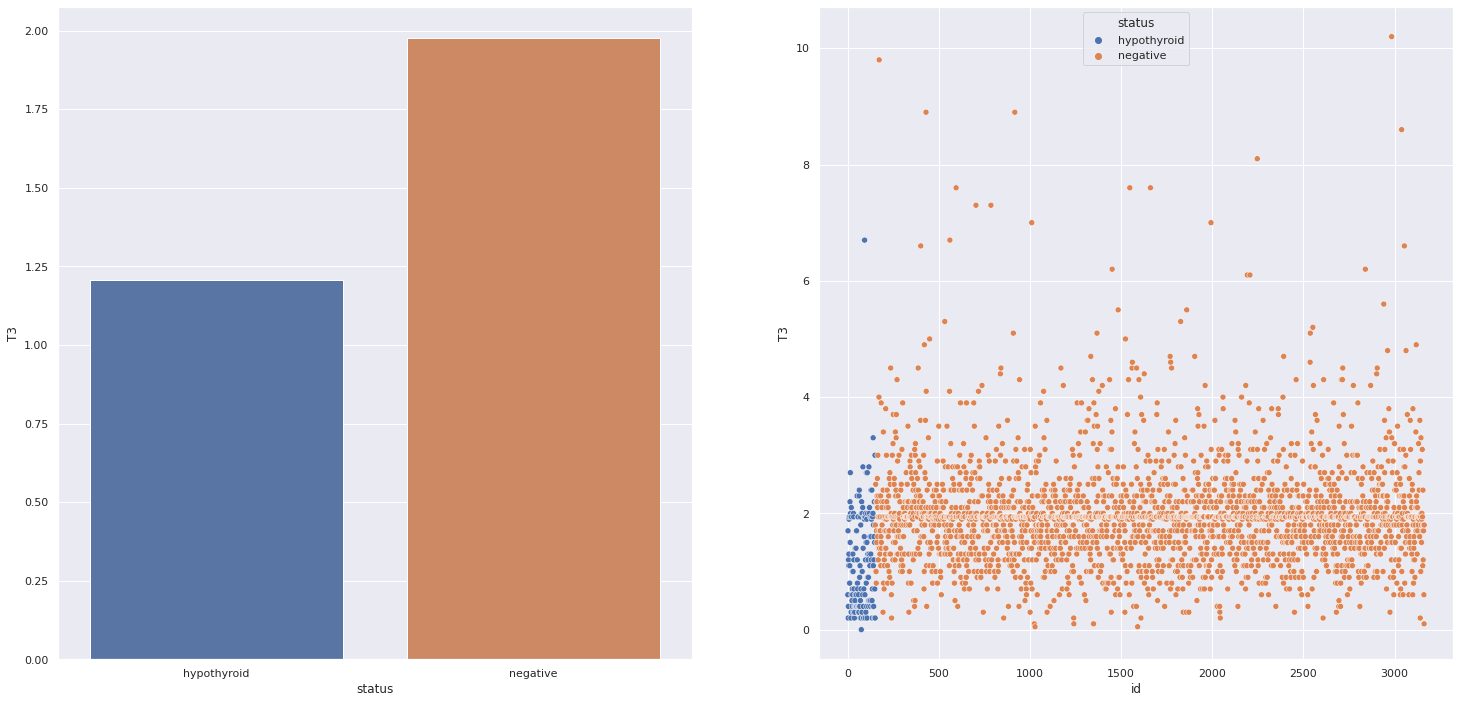

In [ ]:
aux2 = df1[['status', 'T3']].groupby( 'status' ).sum().reset_index()
plt.subplot(1,2,1)
sns.barplot( x='status', y='T3', data=df1, ci=None)


plt.subplot(1,2,2)
sns.scatterplot(data=df1, x="id", y="T3", hue="status")


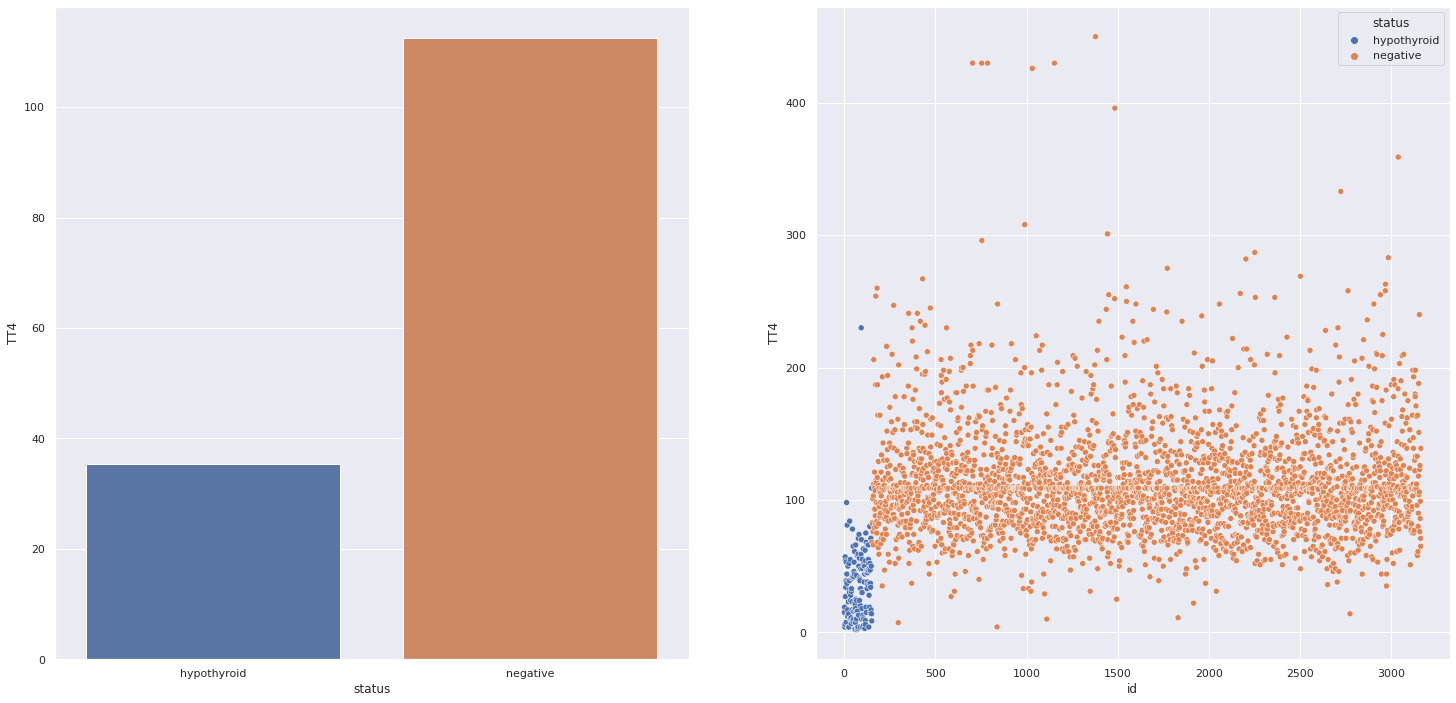

In [ ]:
#Hypothroid cases have significantly low thyroxine levels ((TT4))
aux3 = df1[['status', 'TT4']].groupby( 'status' ).sum().reset_index()
plt.subplot(1,2,1)
sns.barplot( x='status', y='TT4', data=df1, ci=None)

plt.subplot(1,2,2)
sns.scatterplot(data=df1, x="id", y="TT4", hue="status")


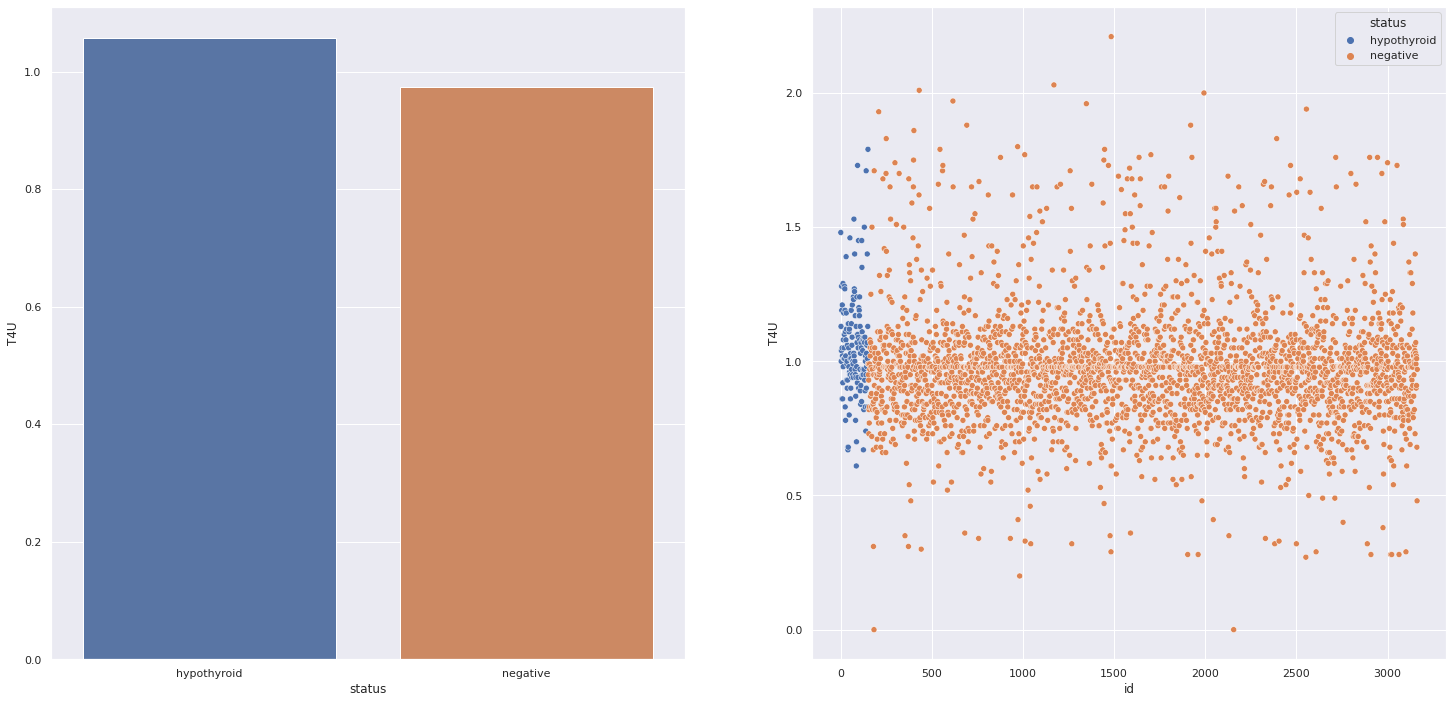

In [ ]:
aux4 = df1[['status', 'T4U']].groupby( 'status' ).sum().reset_index()
plt.subplot(1,2,1)
sns.barplot( x='status', y='T4U', data=df1, ci=None)


plt.subplot(1,2,2)
sns.scatterplot(data=df1, x="id", y="T4U", hue="status")


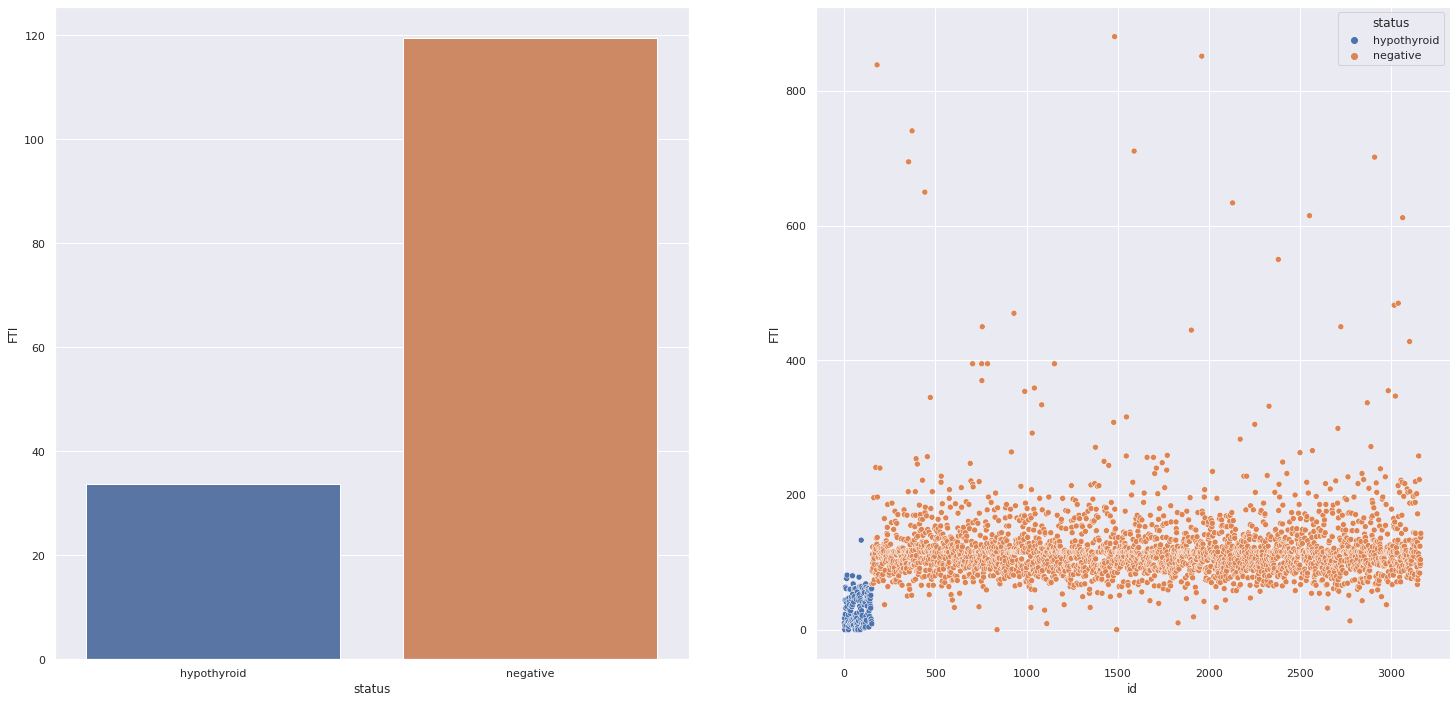

In [ ]:
aux5 = df1[['status', 'FTI']].groupby( 'status' ).sum().reset_index()
plt.subplot(1,2,1)
sns.barplot( x='status', y='FTI', data=df1, ci=None)

plt.subplot(1,2,2)
sns.scatterplot(data=df1, x="id", y="FTI", hue="status")


In [ ]:
df1.sample()

,status,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,thyroid_surgery,query_hypothyroid,query_hyperthyroid,pregnant,sick,tumor,lithium,goitre,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,id
1479,negative,64,F,f,f,t,f,f,f,f,f,f,f,f,y,2.6,y,2.0,y,103.0,y,1.01,y,102.0,n,1480


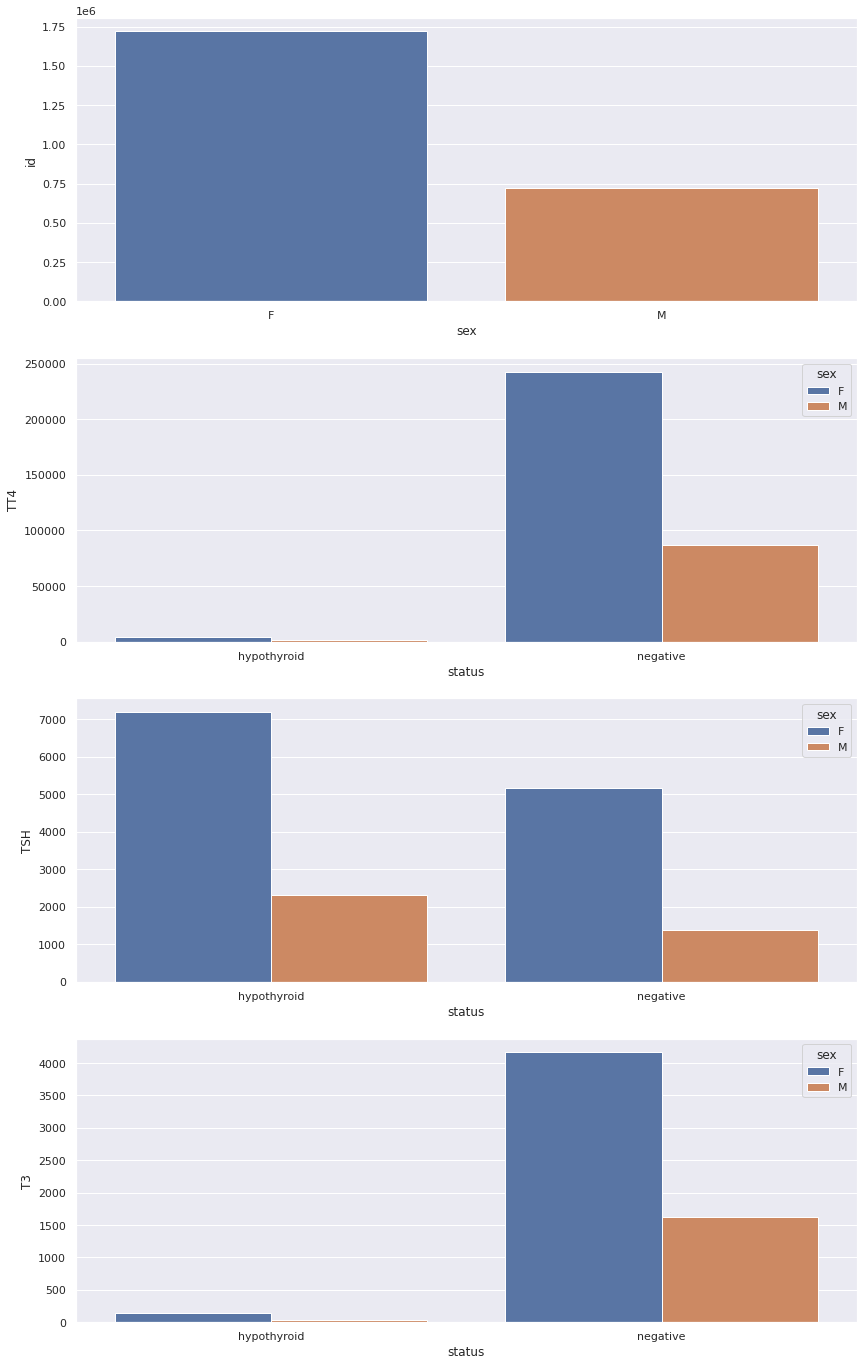

In [ ]:
aux6 = df1[(df1['sex'] != '?')] [['id', 'status', 'sex', 'TT4', 'TSH', "T3"]].groupby( ['sex','status'] ).sum().reset_index()
plt.figure(figsize=(14,24)) 
plt.subplot(4,1,1)
sns.barplot( x='sex', y='id', data=aux6, ci=None)

plt.subplot(4,1,2)
sns.barplot( x='status', y='TT4', hue='sex', data=aux6, ci=None )

plt.subplot(4,1,3)
sns.barplot( x='status', y='TSH', hue='sex', data=aux6, ci=None )

plt.subplot(4,1,4)
sns.barplot( x='status', y='T3', hue='sex', data=aux6, ci=None )

In [ ]:
df1.sample()

,status,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,thyroid_surgery,query_hypothyroid,query_hyperthyroid,pregnant,sick,tumor,lithium,goitre,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,id
2677,negative,NaN,M,f,t,f,f,f,f,f,f,f,f,f,n,0.978199,n,1.939749,y,86.0,y,0.92,y,94.0,n,2678


Text(0.5, 1.0, 'Hypthroid cases by Age and Gender ')

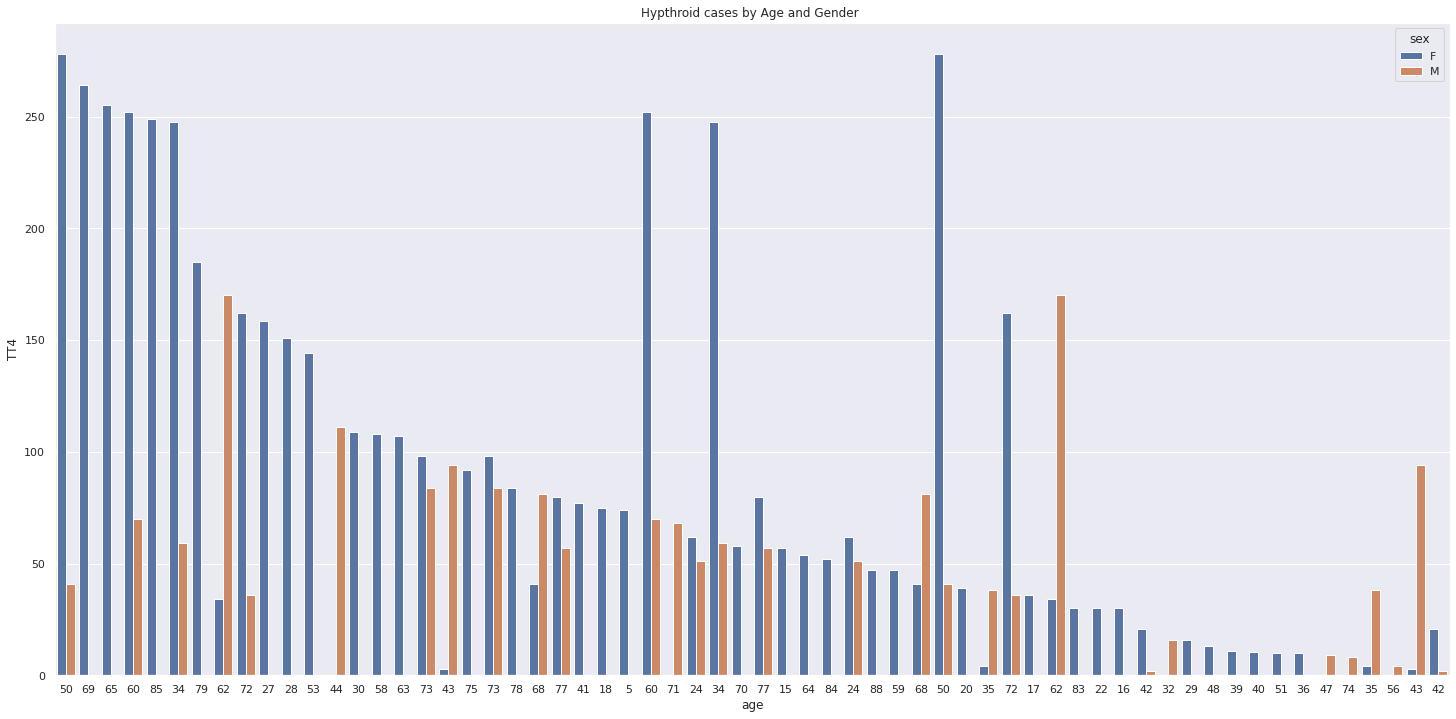

In [ ]:
# It is clear that females have more cases of hypothyroid esp age 50 to 60
aux1 = df1[( df1['status'] == 'hypothyroid' ) & (df1['sex'] != '?')] [['age', 'sex', 'TT4']].groupby( ['age', 'sex']).sum().reset_index()
splot = sns.barplot( x='age',
            y='TT4',
            hue = 'sex',
            order = aux1.sort_values('TT4',ascending = False).age,          
            data=aux1)
plt.title("Hypthroid cases by Age and Gender ")

In [ ]:
cat_attributes.sample()

,status,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,thyroid_surgery,query_hypothyroid,query_hyperthyroid,pregnant,sick,tumor,lithium,goitre,TSH_measured,T3_measured,TT4_measured,T4U_measured,FTI_measured,TBG_measured
1955,negative,60,F,t,f,f,f,t,f,f,f,f,f,f,y,y,y,y,y,n


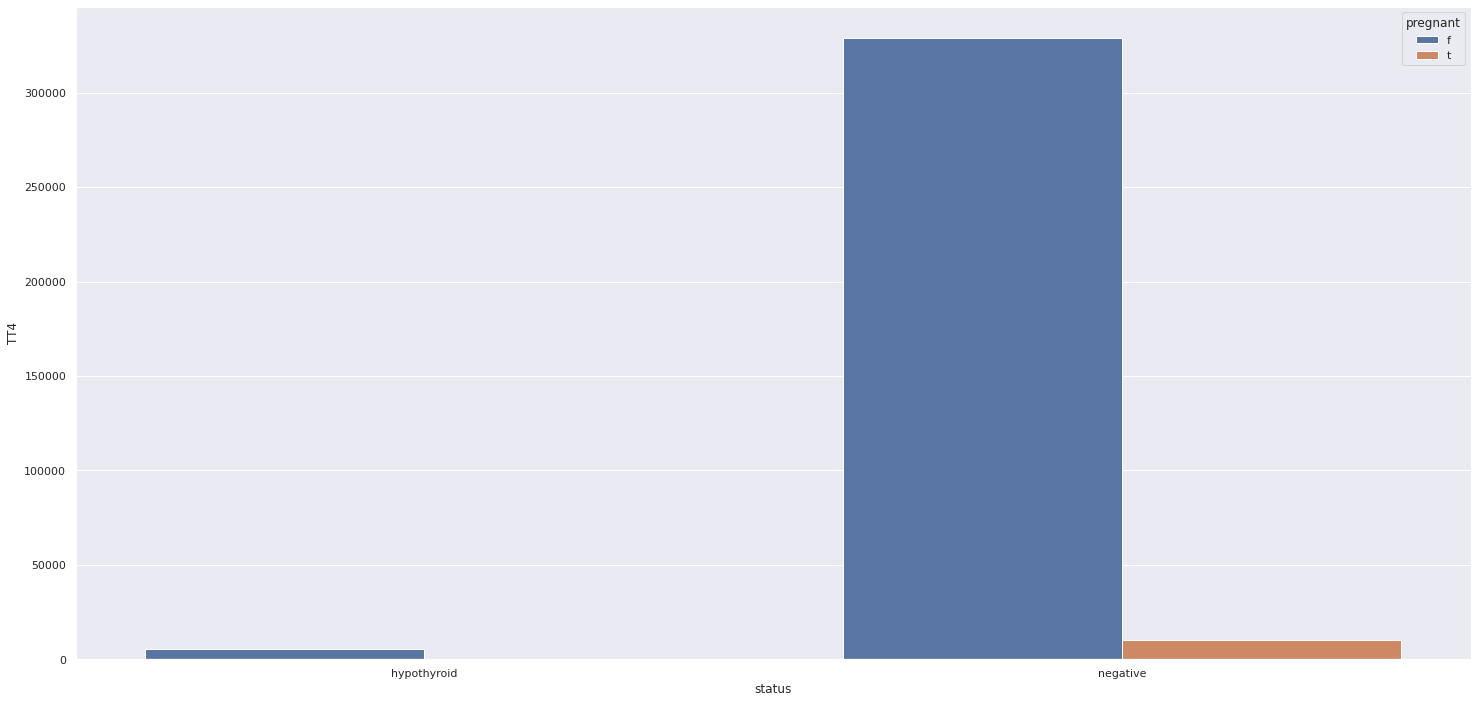

In [ ]:
aux1 = df1[['pregnant','status', "TT4"]].groupby( ['pregnant', 'status'] ).sum().reset_index()
sns.barplot(x = 'status', y= 'TT4', hue = 'pregnant',data = aux1)

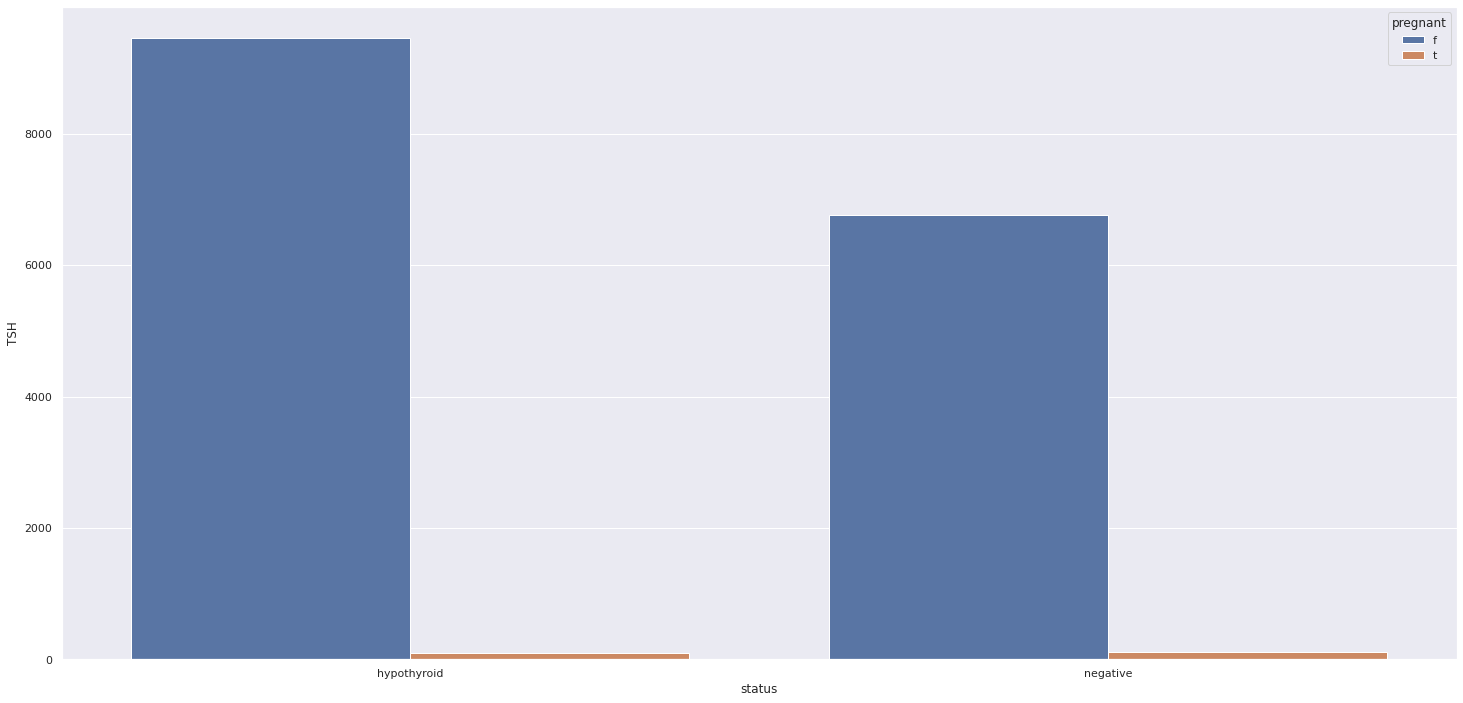

In [ ]:
aux1 = df1[['pregnant','status', "TSH"]].groupby( ['pregnant', 'status'] ).sum().reset_index()
sns.barplot(x = 'status', y= 'TSH', hue = 'pregnant',data = aux1)

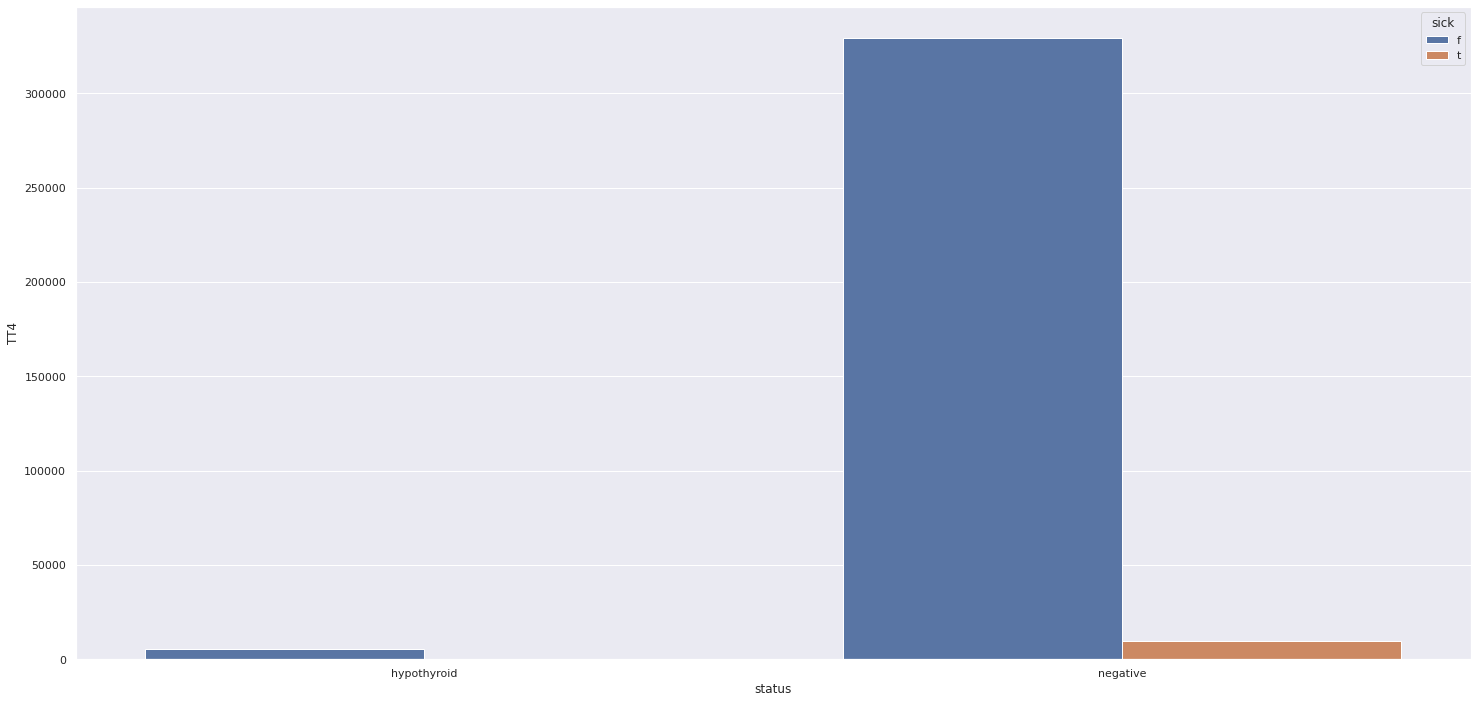

In [ ]:
aux2 = df1[['sick','status', "TT4"]].groupby( ['sick', 'status'] ).sum().reset_index()
sns.barplot(x = 'status', y= 'TT4', hue = 'sick',data = aux2)

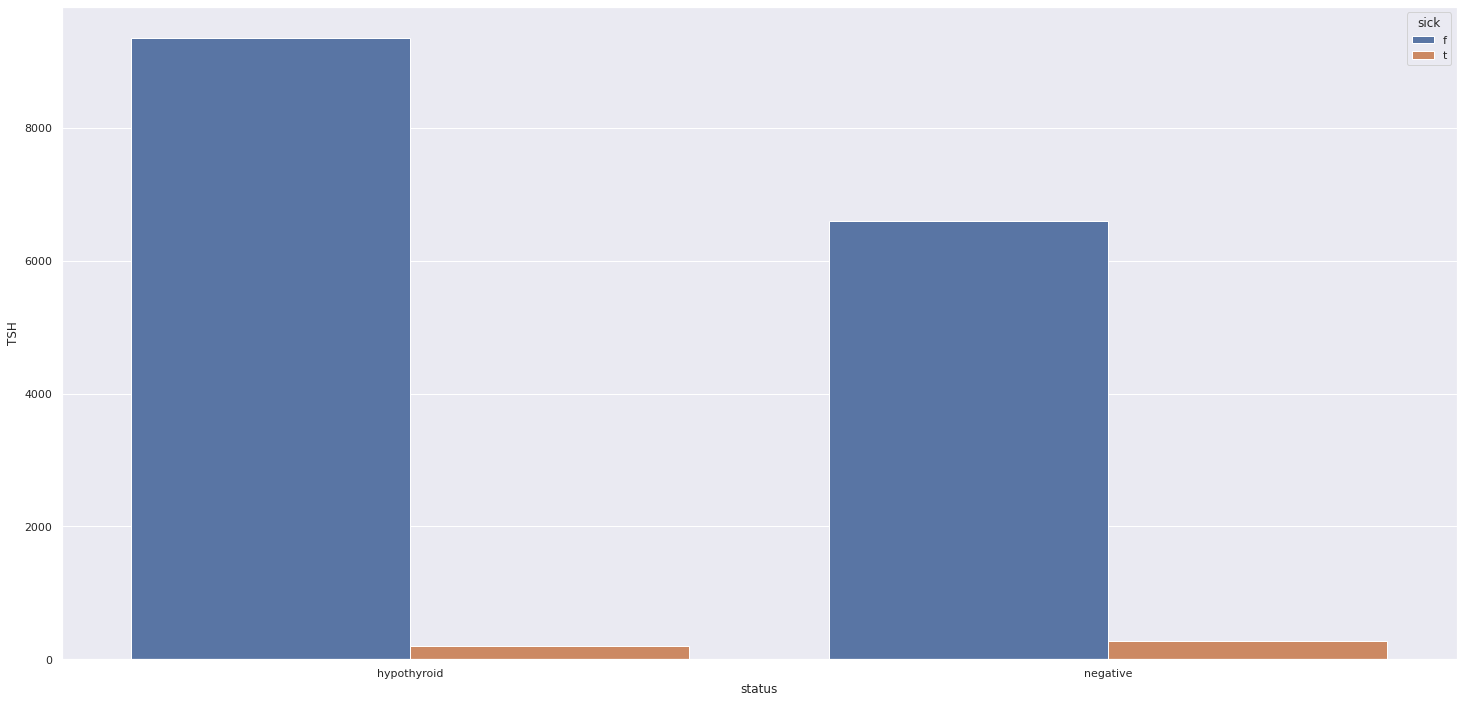

In [ ]:
aux2 = df1[['sick','status', "TSH"]].groupby( ['sick', 'status'] ).sum().reset_index()
sns.barplot(x = 'status', y= 'TSH', hue = 'sick',data = aux2)

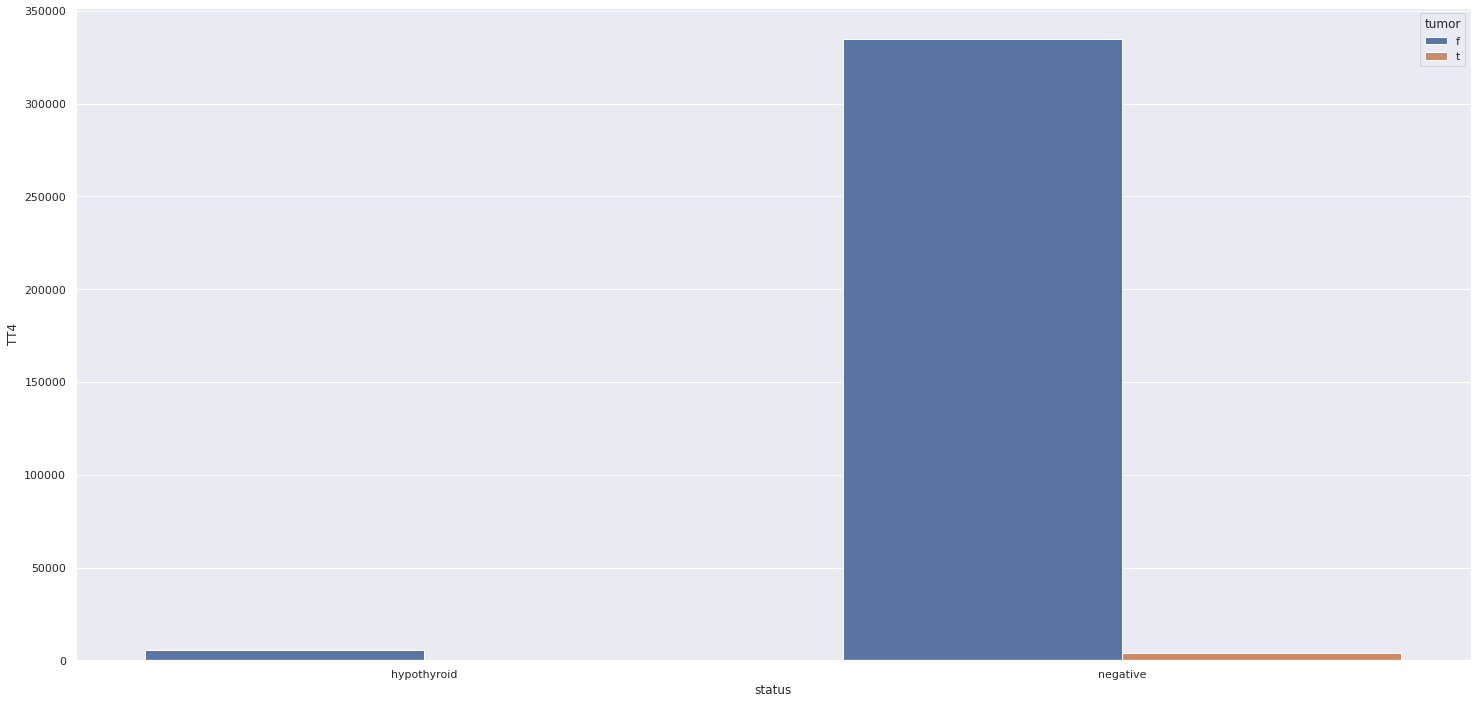

In [ ]:
aux3 = df1[['tumor','status', "TT4"]].groupby( ['tumor', 'status'] ).sum().reset_index()
sns.barplot(x = 'status', y= 'TT4', hue = 'tumor',data = aux3)

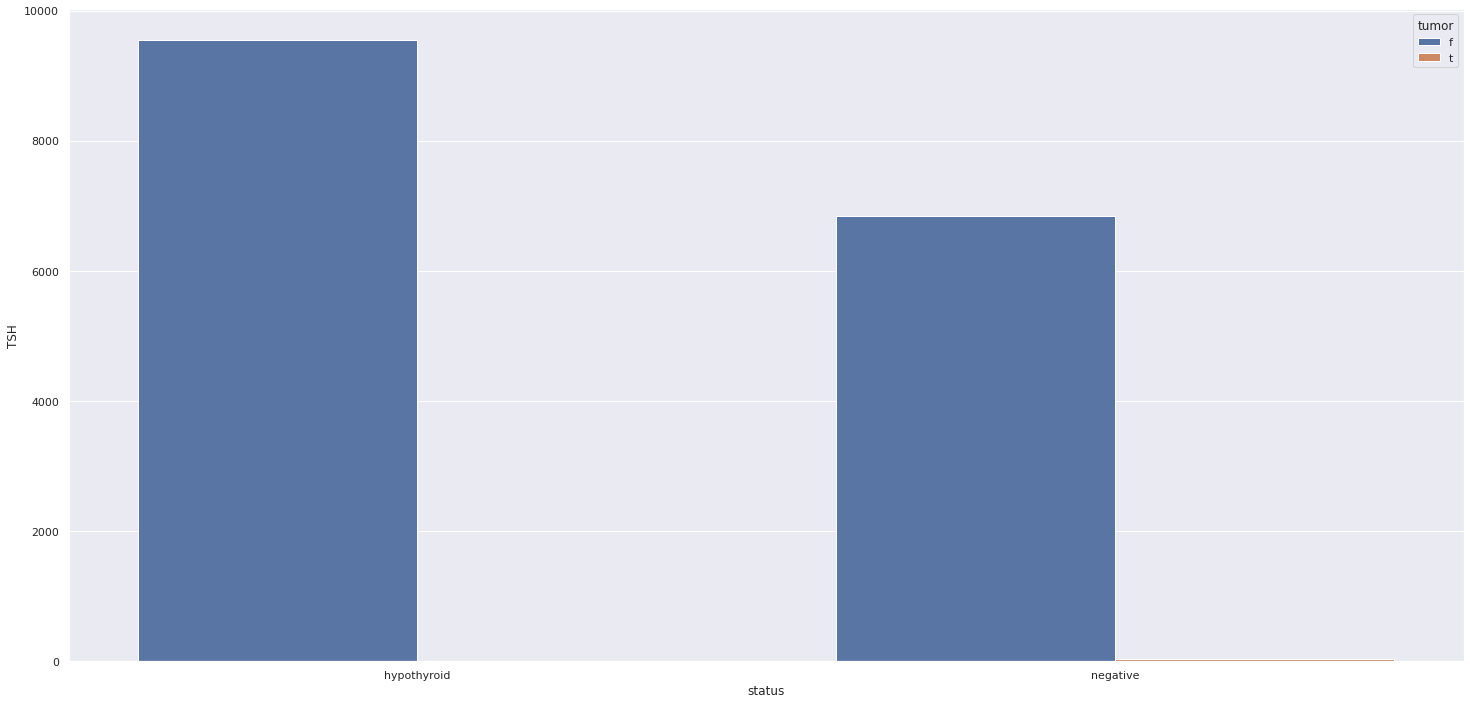

In [ ]:
aux3 = df1[['tumor','status', "TSH"]].groupby( ['tumor', 'status'] ).sum().reset_index()
sns.barplot(x = 'status', y= 'TSH', hue = 'tumor',data = aux3)

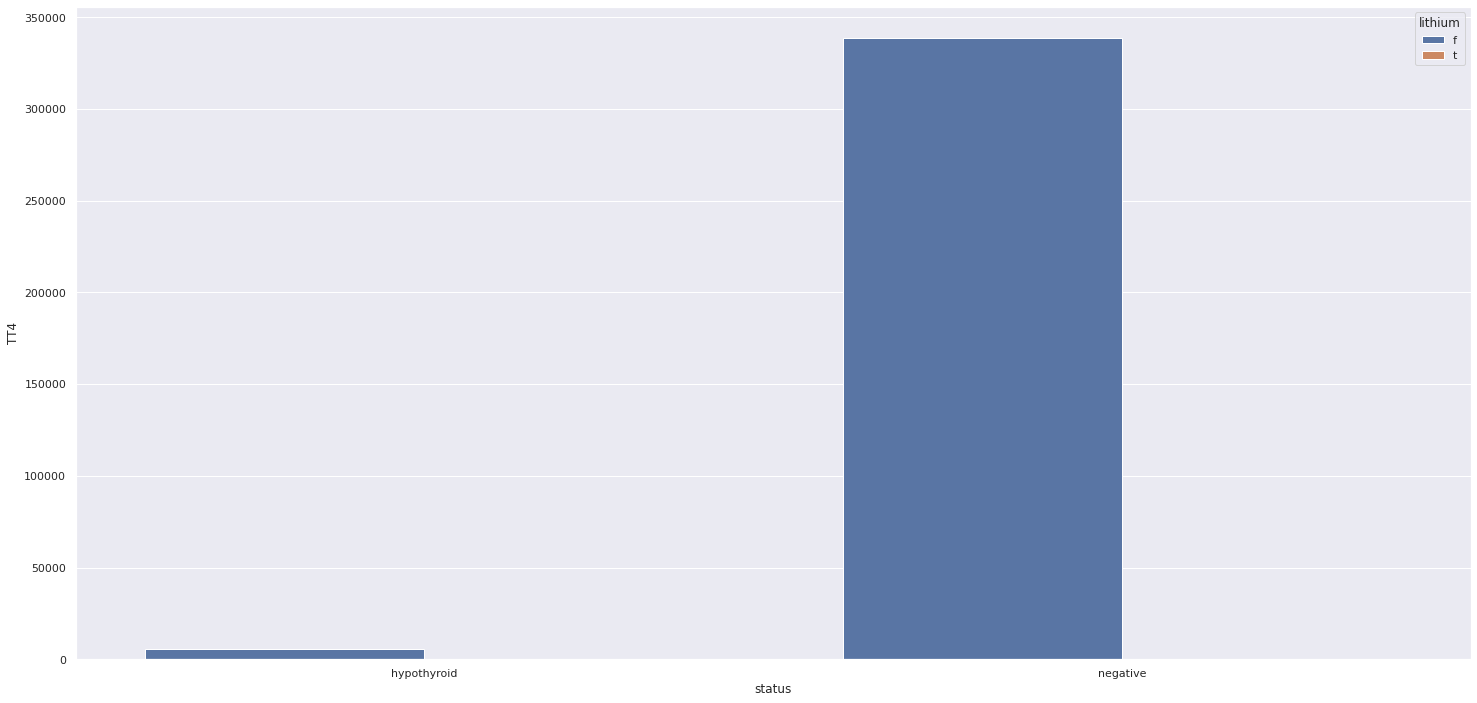

In [ ]:
aux5 = df1[['lithium','status', "TT4"]].groupby( ['lithium', 'status'] ).sum().reset_index()
sns.barplot(x = 'status', y= 'TT4', hue = 'lithium',data = aux5)

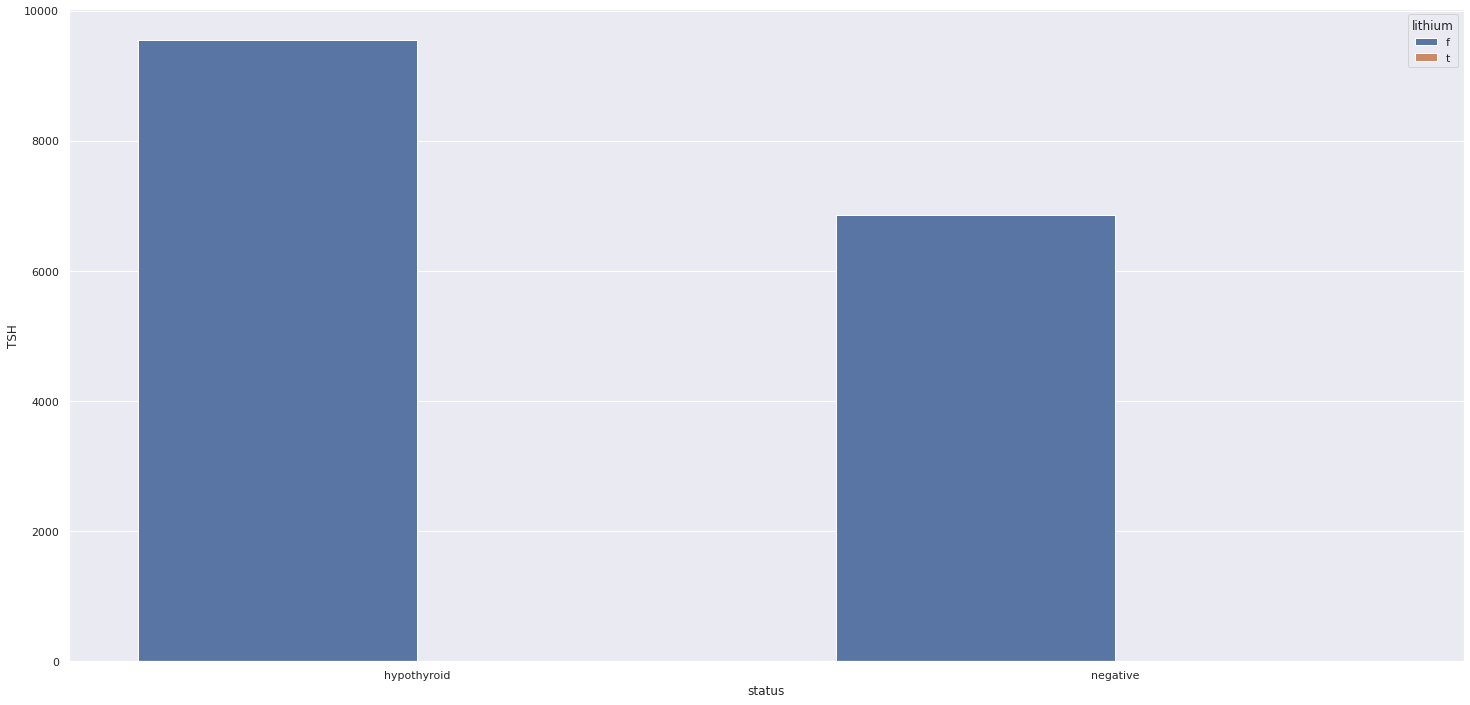

In [ ]:
aux5 = df1[['lithium','status', "TSH"]].groupby( ['lithium', 'status'] ).sum().reset_index()
sns.barplot(x = 'status', y= 'TSH', hue = 'lithium',data = aux5)

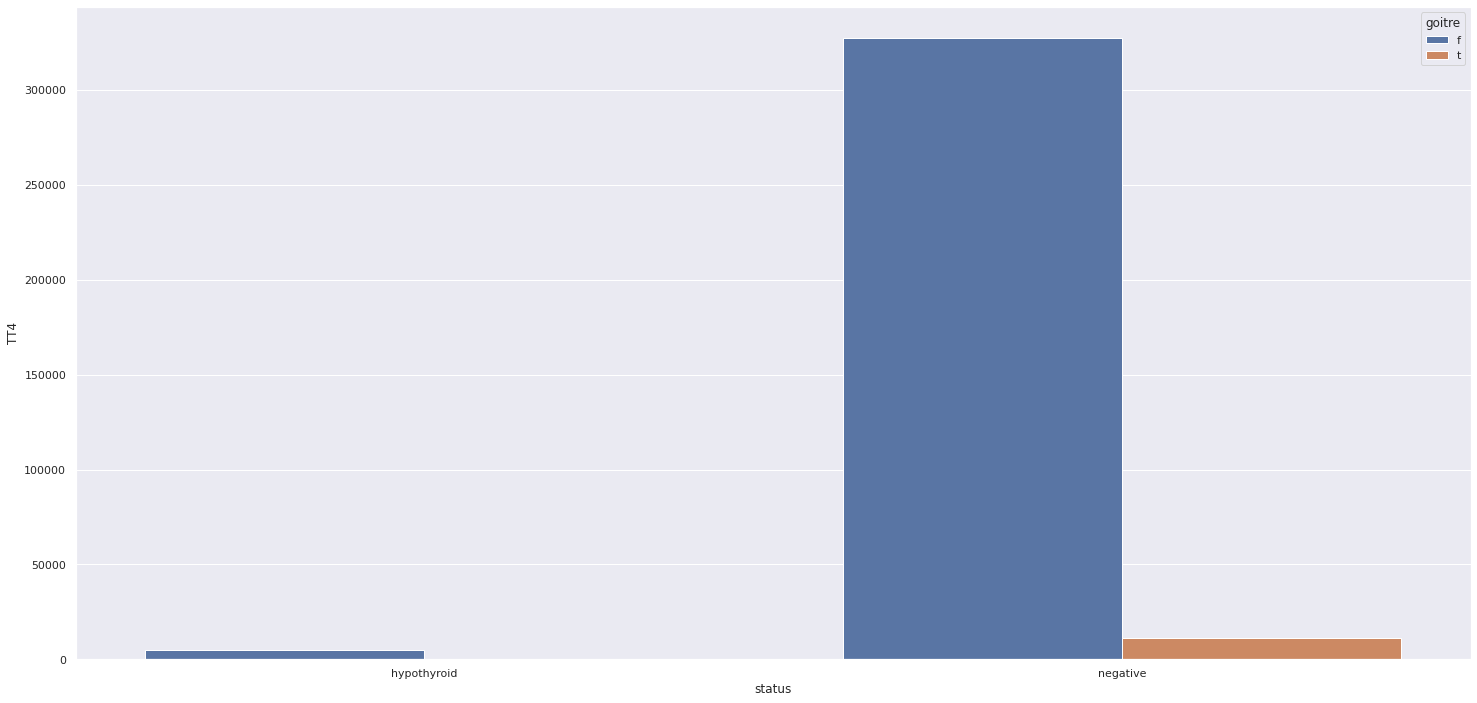

In [ ]:
aux6 = df1[['goitre','status', "TT4"]].groupby( ['goitre', 'status'] ).sum().reset_index()
sns.barplot(x = 'status', y= 'TT4', hue = 'goitre',data = aux6)

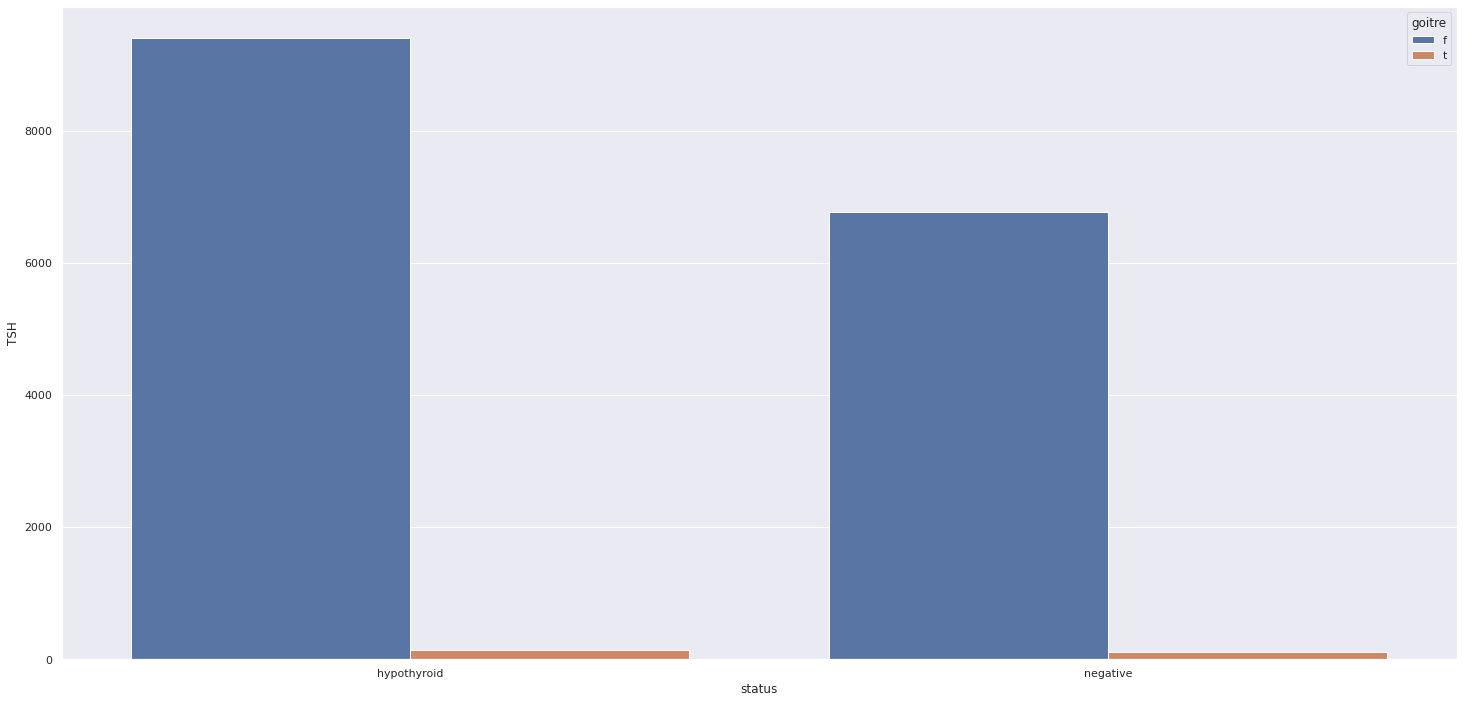

In [ ]:
aux6 = df1[['goitre','status', "TSH"]].groupby( ['goitre', 'status'] ).sum().reset_index()
sns.barplot(x = 'status', y= 'TSH', hue = 'goitre',data = aux6)

## 3.3 Multivarite Analysis


###3.3.1. Numerical Attributes

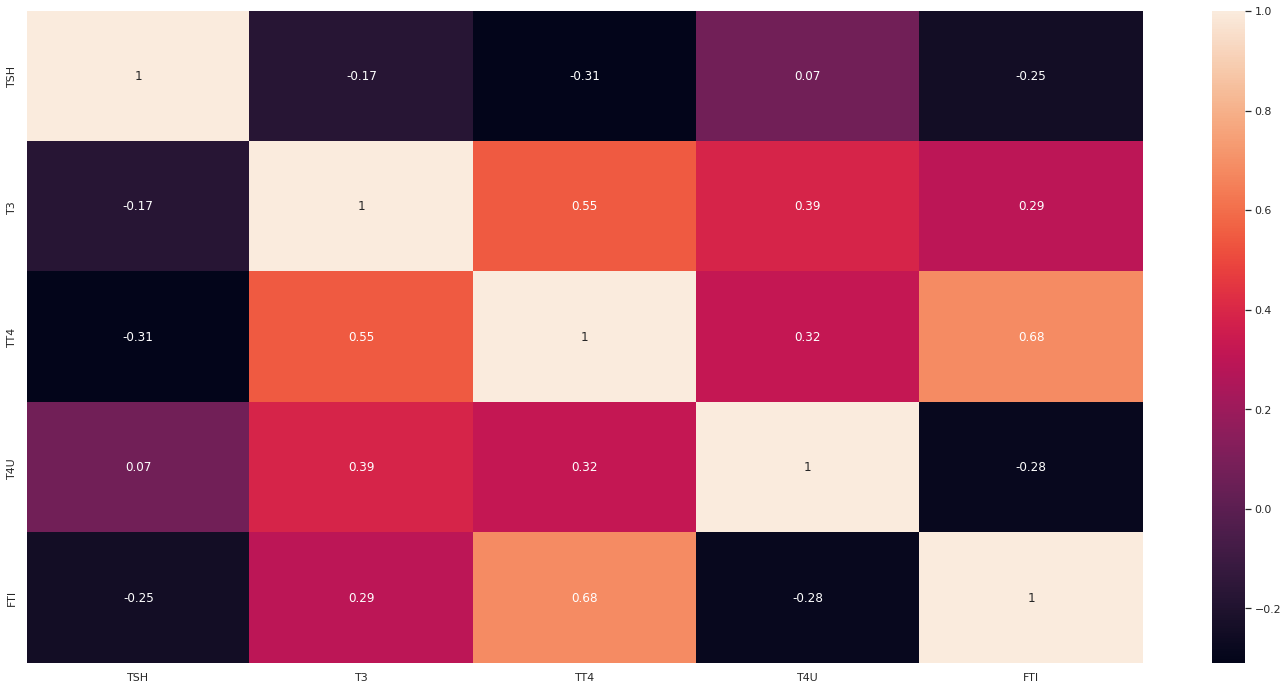

In [ ]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True )

# 4.0 Data Preparation

In [ ]:
df2 = df1.copy()

In [ ]:
df2.sample()

,status,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,thyroid_surgery,query_hypothyroid,query_hyperthyroid,pregnant,sick,tumor,lithium,goitre,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,id
2370,negative,75,F,f,f,f,f,f,f,f,f,f,f,f,y,0.7,y,1.6,y,107.0,y,1.01,y,106.0,n,2371


##4.1 Rescaling

In [ ]:
a = df2.select_dtypes( include=['int64', 'float64'] )

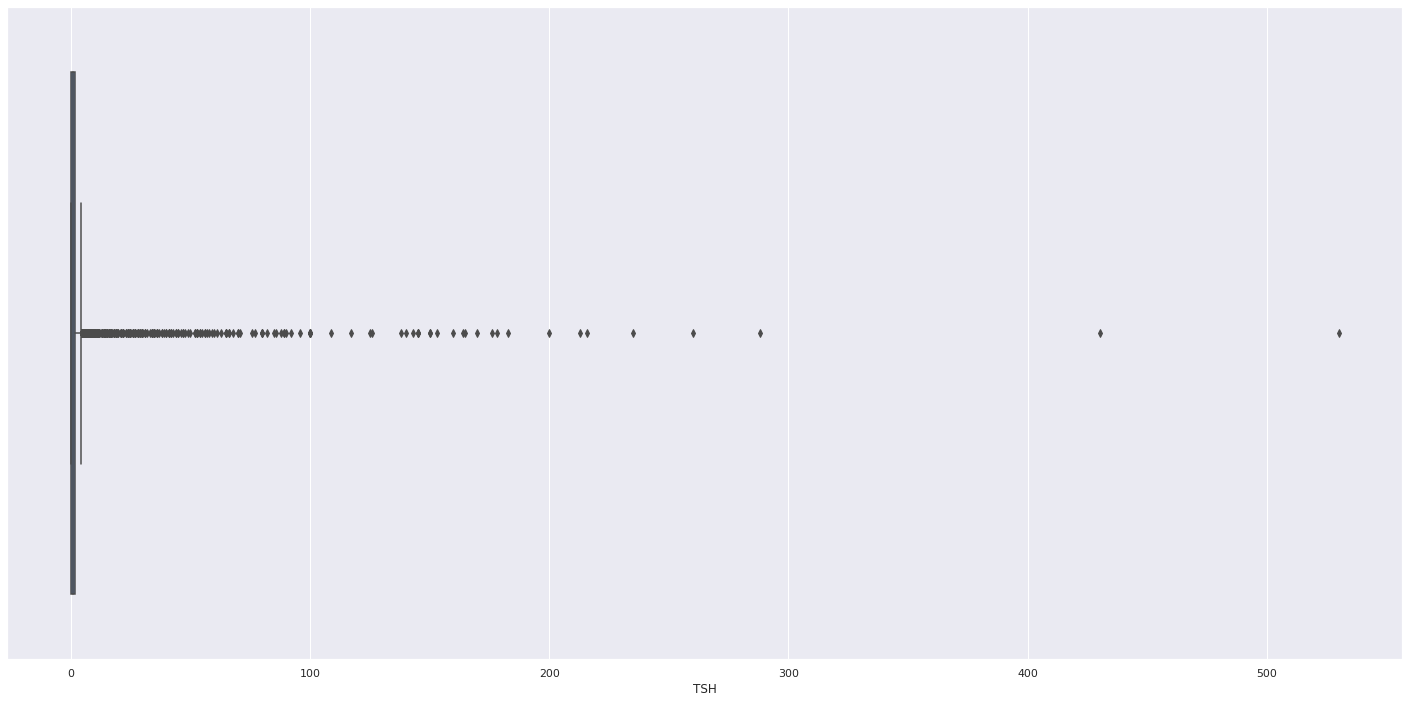

In [ ]:
sns.boxplot( df2['TSH'] )

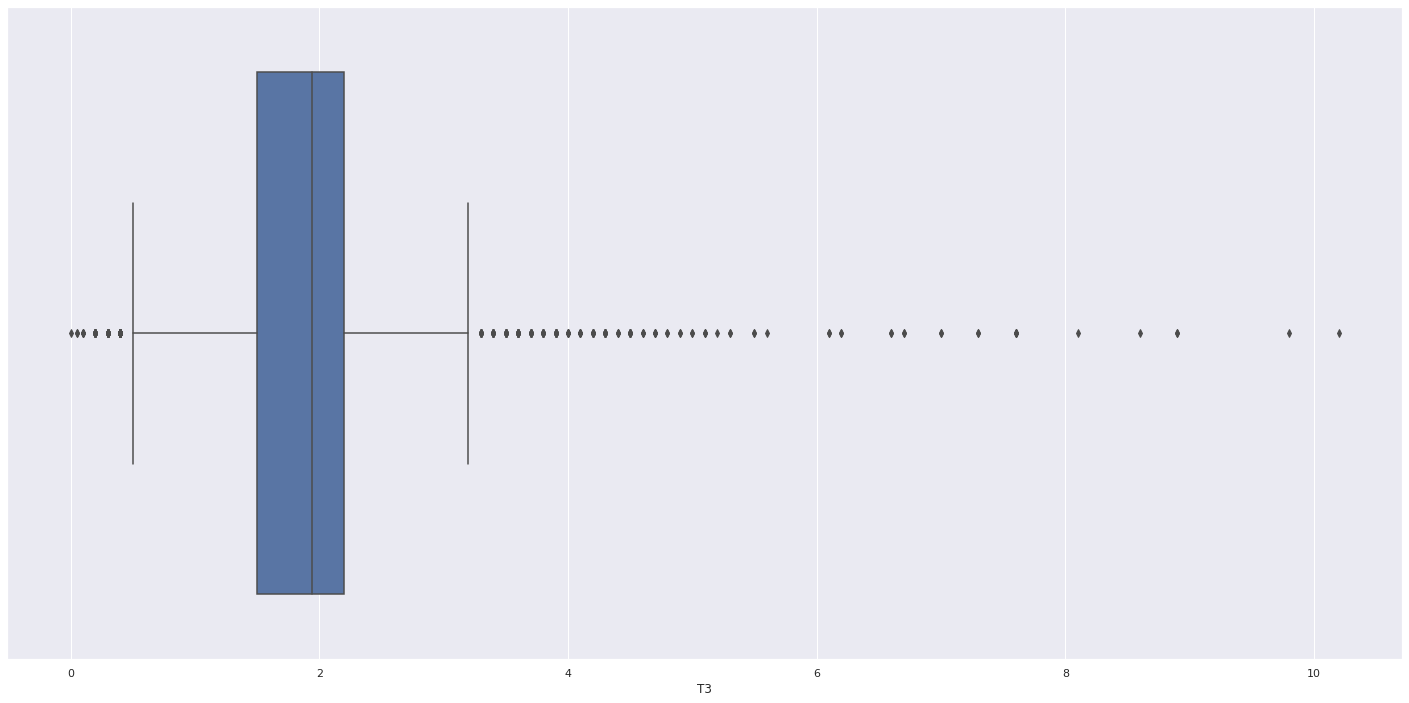

In [ ]:
sns.boxplot( df2['T3'] )

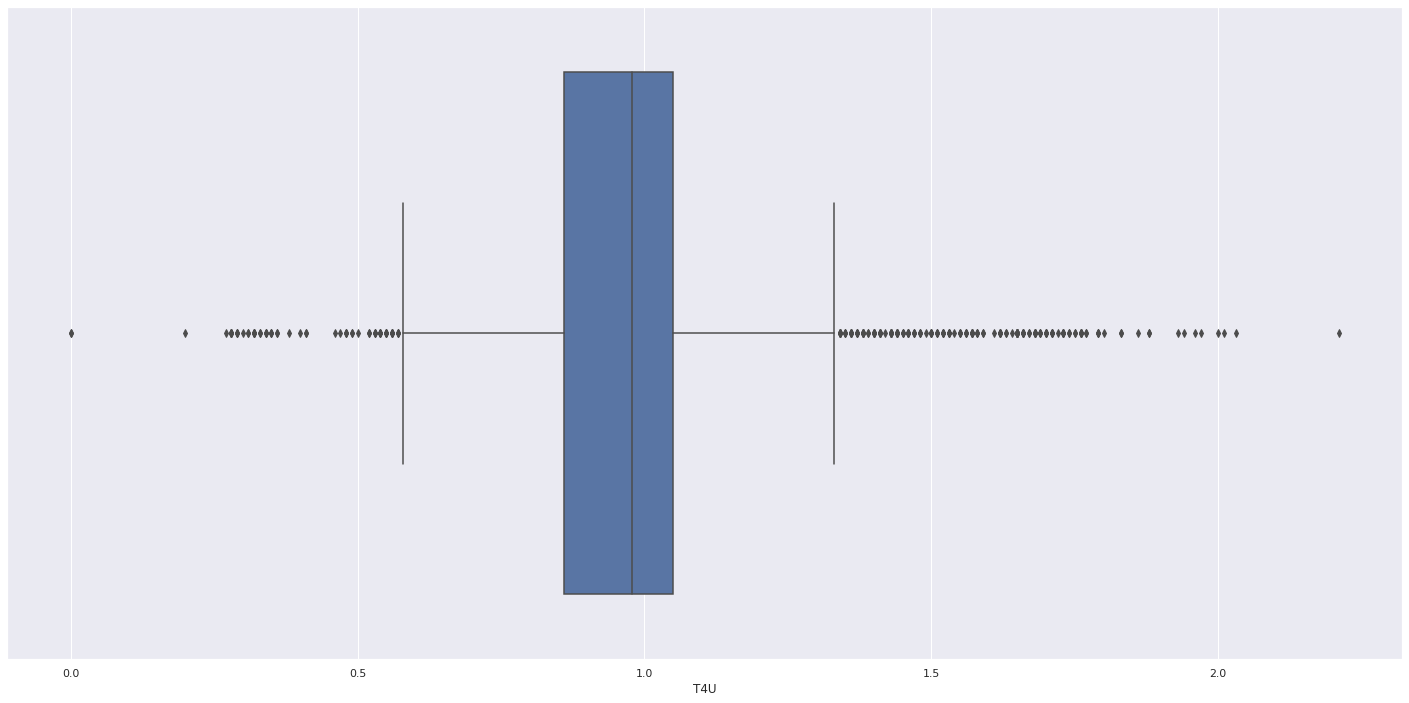

In [ ]:
sns.boxplot( df2['T4U'] )

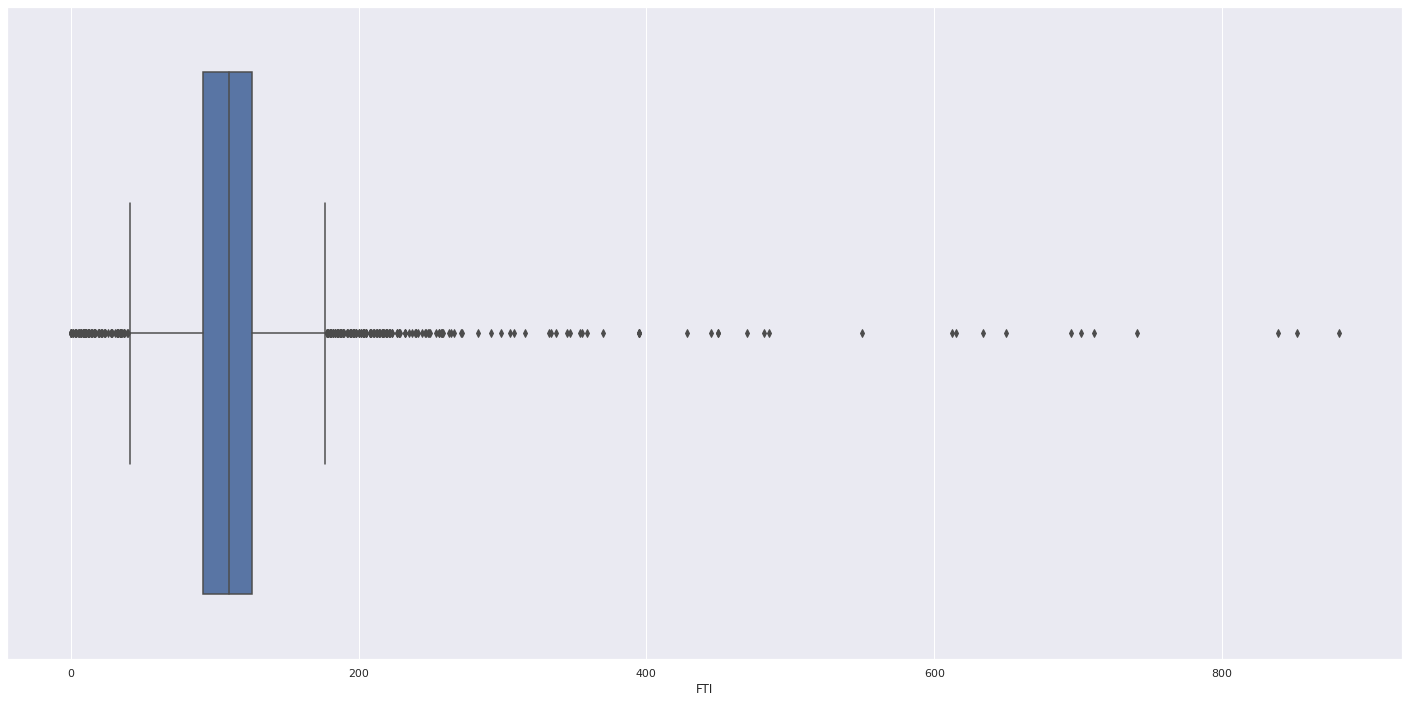

In [ ]:
sns.boxplot( df2['FTI'] )

In [ ]:
a.sample()

,TSH,T3,TT4,T4U,FTI,id
1545,1.4,2.2,149.0,1.29,115.0,1546


In [ ]:
# This Scaler removes the median and scales the
# data according to the quantile range (defaults to IQR: Interquartile Range). 
# The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

rs = RobustScaler()

# TSH
df2['TSH'] = rs.fit_transform( df2[['TSH']].values )

# TT4
df2['TT4'] = rs.fit_transform( df2[['TT4']].values )

# T3
df2['T3'] = rs.fit_transform( df2[['T3']].values )

#T4U
df2['T4U'] = rs.fit_transform( df2[['T4U']].values )

#FTI
df2['FTI'] = rs.fit_transform( df2[['T3']].values )

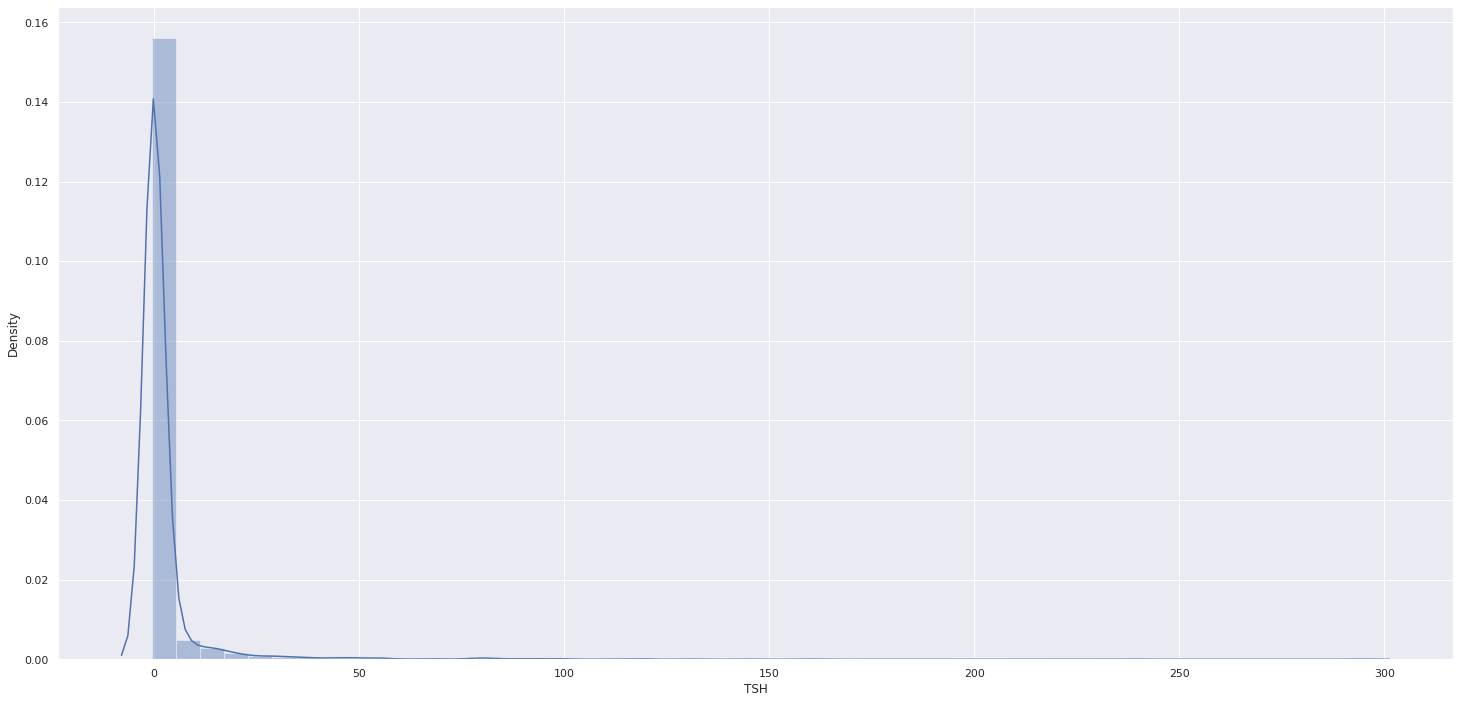

In [ ]:
sns.distplot( df2['TSH'] )

#4.2 Transformation

###4.2.1 Encoding

In [ ]:
df2.sample()

,status,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,thyroid_surgery,query_hypothyroid,query_hyperthyroid,pregnant,sick,tumor,lithium,goitre,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,id
184,negative,59,F,f,f,f,f,f,f,f,f,f,f,f,n,0.0,y,-0.628213,y,-0.25641,y,-0.358942,y,-0.628213,n,185


In [ ]:
# Status - One Hot Encoding
df2 = pd.get_dummies( df2, prefix=['status'], columns=['status'] )

# Sex - One Hot Encoding
df2 = pd.get_dummies( df2, prefix=['sex'], columns=['sex'] )

# Pregnant- One Hot Encoding
df2 = pd.get_dummies( df2, prefix=['pregnant'], columns=['pregnant'] )

# Tumor- One Hot Encoding
df2 = pd.get_dummies( df2, prefix=['tumor'], columns=['tumor'] )

# Goitre- One Hot Encoding
df2 = pd.get_dummies( df2, prefix=['goitre'], columns=['goitre'] )


# 5.0 Feature Selection

In [ ]:
df3 = df2.copy()

In [ ]:
df3.shape

(3163, 31)

In [ ]:
df3.sample()

,age,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,thyroid_surgery,query_hypothyroid,query_hyperthyroid,sick,lithium,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,id,status_hypothyroid,status_negative,sex_F,sex_M,pregnant_f,pregnant_t,tumor_f,tumor_t,goitre_f,goitre_t
1173,52,f,f,f,f,f,f,f,f,y,-0.154555,y,-1.056784,y,-0.948718,y,-0.990521,y,-1.056784,n,1174,0,1,1,0,1,0,1,0,1,0


In [ ]:
# First I will drop the columns that I will not use. Basically they are the columns that
# were only used to generate new columns in the Feature Engineering process.
cols_drop = [ 'on_thyroxine', 'query_on_thyroxine', 
             'on_antithyroid_medication', 'thyroid_surgery',
             'query_hypothyroid', 'sick', 'lithium', 'TSH_measured',
              'T3_measured', 'T4U_measured','FTI_measured', 'TBG_measured',
             'id','query_hyperthyroid', 'TT4_measured'	]

df3 = df3.drop( cols_drop, axis=1 )

In [ ]:
df4 =df3.copy()

#6.0 Machine Learning

In [ ]:
# Before continuing into sessions that we will implement the Machine Learning models,
# I would like to explain about the error meanings.

# MAE:
# It is usually what I use to report to the business team because is easier to explain.
# It takes the absolute value of the difference between the real and the predicted 
# number and divides it by the number of predictions, that is, for each value that
# the model predicts it varies the MAE value on average (both for more and for less).
# Due to the way the MAE is calculated, it is not sensitive to outliers.
# If I'm on a project where having an outlier-sensitive error is super important 
#I will use to evaluate my model another error.

# MAPE:
# It is also used to facilitate the understanding of the business team about the error of your model. 
# The MAPE simply represents the percentage of the MAE, 
# that is, how much the error that the model has means in percentage of the real value.

# RMSE:
# This is the error most used by data scientists to measure the performance
# of the model and its value serves as a parameter in the process of trying 
# to decrease the model error within the project.
# This high use of RMSE is due to the fact that it is sensitive to outliers 
# and this helps data scientists to be more rigorous with model errors.
# In cases where detecting the presence of outliers is important within 
# the project I use RMSE instead of MAE.


##6.1 Linear Regression Model

In [ ]:
# Separate independent variables and dependent variable

X = df2[["TSH", "FTI", 'T3']].values
y = df2["TT4"].values

In [ ]:
# Train using 80% of the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [ ]:
# Train using 80% of the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# find optimal coefficients and intercept
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

# assess the accuraccy of the model
y_pred = regressor.predict(X_test)

a = pd.DataFrame( {'Model Name': 'Linear Regression',
                  'Mean Absolute Error': metrics.mean_absolute_error(y_test, y_pred), 
                  'Mean Absolute Percentage Error':np.mean(np.abs((y_test - y_pred) / y_test)) * 100,
                  'Mean Squared Error':  metrics.mean_squared_error(y_test, y_pred) , 
                  'Root Mean Squared Error': np.sqrt(metrics.mean_squared_error(y_test, y_pred)) }, index=[0])



In [ ]:
a

,Model Name,Mean Absolute Error,Mean Absolute Percentage Error,Mean Squared Error,Root Mean Squared Error
0,Linear Regression,0.619163,inf,0.759612,0.871557


##6.2 Linear Regression Cross Validation


In [ ]:
folds = KFold(n_splits=5)

# note that if you have a KFold object, you can figure out how many folds you set up 
# for it using get_n_splits
print('we are using ' +str(folds.get_n_splits(X)) + ' folds')


# We now create and assess 5 models based on the folds we created.
RMSES = [] # We will use this array to keep track of the RSME of each model
count = 1 # This will just help 
for train_index, test_index in folds.split(X):
  print('\nTraining model ' + str(count))
  
  # set up the train and test based on the split determined by KFold
  # With 5 folds, we will end up with 80% of our data in the training set, and 20% in the test set, just as above
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  
  # fit a model accordingly
  regressor = LinearRegression()  
  regressor.fit(X_train, y_train)
  
  # assess the accuraccy of the model
  y_pred = regressor.predict(X_test)
  
  rmse_value =  np.sqrt(metrics.mean_squared_error(y_test, y_pred))
  RMSES.append(rmse_value)
  
  print('Model ' + str(count) + ' Root Mean Squared Error:',rmse_value)
  count = count + 1

least = RMSES[-2]


we are using 5 folds

Training model 1
Model 1 Root Mean Squared Error: 0.9501413849499168

Training model 2
Model 2 Root Mean Squared Error: 1.0389294608980442

Training model 3
Model 3 Root Mean Squared Error: 0.882726527192289

Training model 4
Model 4 Root Mean Squared Error: 0.7983813747552119

Training model 5
Model 5 Root Mean Squared Error: 0.8697943910045813


In [ ]:
b = pd.DataFrame( {'Model Name': 'Linear Regression CV',
                  'Mean Absolute Error': metrics.mean_absolute_error(y_test, y_pred), 
                  'Mean Absolute Percentage Error':np.mean(np.abs((y_test - y_pred) / y_test)) * 100,
                  'Mean Squared Error':  metrics.mean_squared_error(y_test, y_pred) , 
                  'Root Mean Squared Error': least }, index=[0])

In [ ]:
#Our errors have decreased meaning we heading at the right direction
#What we want to look out for is the RMSE decreasing
b

,Model Name,Mean Absolute Error,Mean Absolute Percentage Error,Mean Squared Error,Root Mean Squared Error
0,Linear Regression CV,0.618751,inf,0.756542,0.798381


##6.2 Support Vector Machines

### 6.2.1 Linear Function


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale=1.2)

# Import Suport Vector Classifier module from svm library. We'll use SVC to model our data
from sklearn.svm import SVC,LinearSVC
from sklearn.model_selection import train_test_split

# Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import  accuracy_score
from sklearn.metrics import confusion_matrix

We are going to implement SVM. As a recap, our aim is to classify a patient whether he or she is siadnosed with Hypothyroid or not. our dataset will comprise of diagnosis if the patient is positive or not.. Remember that high TSH levels means your throid is not making enough thyroid hormones a condition called hypothyroidism.
With a low T4 level indicates hypothyroidism

In [ ]:
df1.sample()

,status,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,thyroid_surgery,query_hypothyroid,query_hyperthyroid,pregnant,sick,tumor,lithium,goitre,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,id
3151,negative,58,F,f,f,f,f,f,f,f,f,f,f,f,y,0.3,y,3.1,y,151.0,y,1.4,y,108.0,n,3152


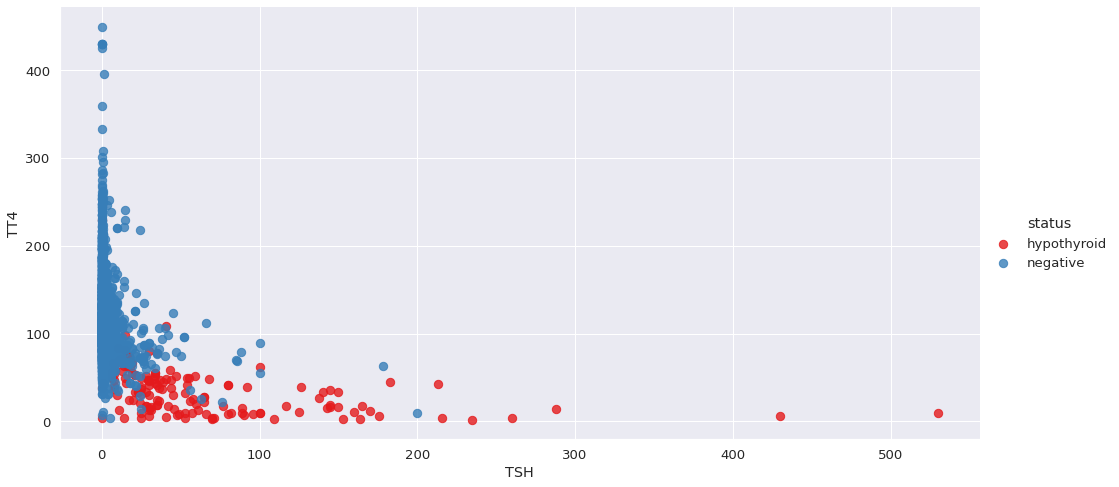

In [ ]:
# We are going to use TSH and T4 as our classifying criteria. 
# So we plot the two columns to see if we can apply svm on them
# Plot two ingredients

sns.lmplot('TSH', 'TT4', data=df1, hue='status',
           palette='Set1',height= 7, aspect=2, fit_reg=False, scatter_kws={"s": 70})


From the graph we can have two classes, positive cases of hypothyroid are indicated by red dots and  negative cases of hypothyroid blue dots. We can also observe that indeed points that have a high concetration of T4 are negative and conversely, the ones that have a high concentration of TSH are negative. Hence we can use svm to train a model that will be able to classify a patient as either a a positive or negative for Hypothyroid

####6.2.1.1Fit the input of the model

In [ ]:
# Specify the input for the model

hypo_negative = df1[['TT4', 'TSH']].values

# Put a label of either a muffin or not and assign it 0 or 1
type_label = np.where(df1['status']=='hypothyroid',0,1)


# Fit the model
model = SVC(kernel= 'linear')
model.fit(hypo_negative,type_label)

SVC(kernel='linear')

#### 6.2.1.2 Visualization

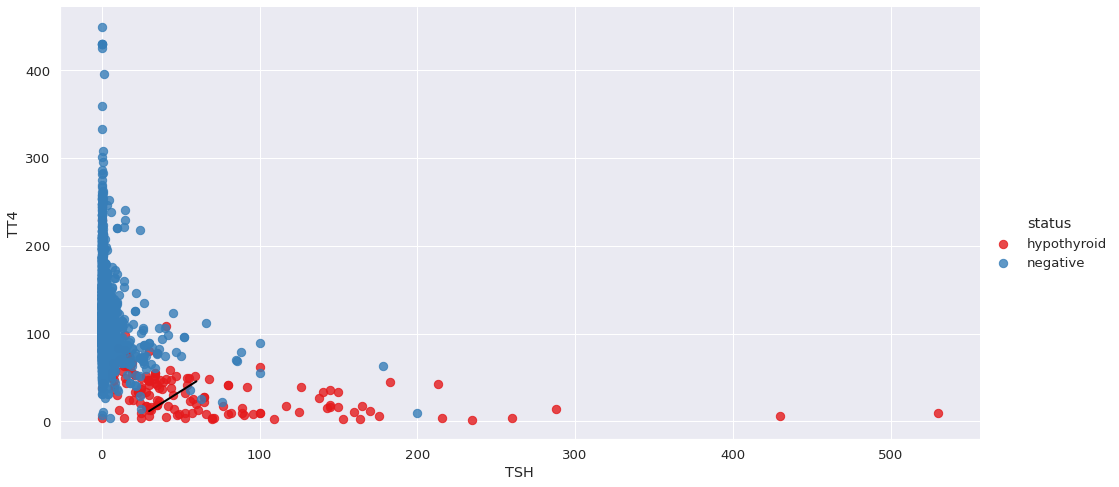

In [ ]:
# Get the separating hyperplane
w = model.coef_[0] #get the first coefficient of our model
a = -w[0] / w[1]

# Get the x values of our hyperplane.
# We achieve this by creating a range numbers from the largest number 
# of the TSH vlaues and the smallest number of the TSH values.  

xx = np.linspace(30, 60)
yy = a * xx - (model.intercept_[0]) / w[1]

# Plot the hyperplane
sns.lmplot('TSH', 'TT4', data=df1, hue='status', palette='Set1', 
           height= 7, aspect=2, fit_reg=False, scatter_kws={"s": 70})
plt.plot(xx, yy, linewidth=2, color='black')


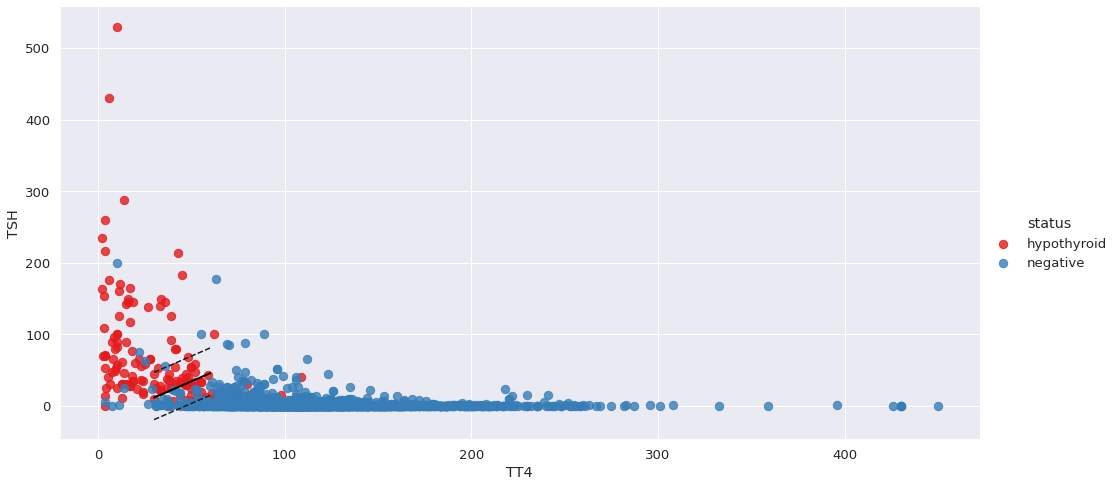

In [ ]:
# Plot the parallels to the separating hyperplane that pass through the support vectors
b = model.support_vectors_[0]
yy_down = a * xx + (b[1] - a * b[0])
b = model.support_vectors_[-1]
yy_up = a * xx + (b[1] - a * b[0])

# Look at the margins and support vectors

sns.lmplot('TT4', 'TSH', data = df1, hue='status', height= 7, aspect=2, 
           palette='Set1', fit_reg=False, scatter_kws={"s": 70})

plt.plot(xx, yy, linewidth=2, color='black')

plt.plot(xx, yy_down, 'k--') #'k--' indicates that we want to draw a black dotted line

plt.plot(xx, yy_up, 'k--')

plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],s=80, facecolors='none');


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale=1.2)
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score

In [ ]:
s = df1[["TT4", "TSH", 'status']]
s['status'] = s['status'].astype('category')

In [ ]:
#linear kernel
# splitting independent var and dependent var
X = s[['TT4', 'TSH']]
y = s['status'].cat.codes


In [ ]:
y.sample(3)

1299    1
3049    1
202     1
dtype: int8

In [ ]:
#scaling features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
#  Split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2530, 2) (2530,)
(633, 2) (633,)


In [ ]:

# Fit the model
model = SVC(kernel= 'linear')
clf_model = model.fit(X_train,y_train)

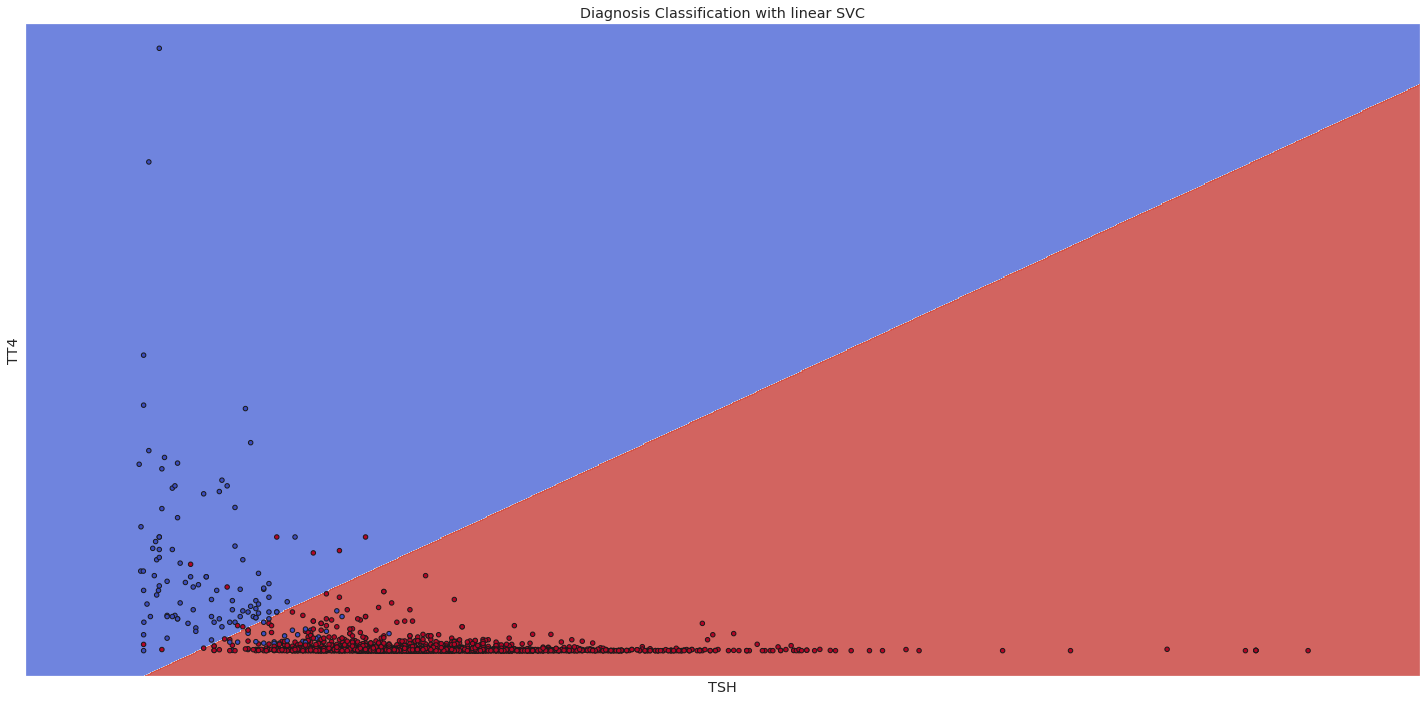

In [ ]:
# Create a mesh grid for our graph
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

# A function that creates the hyperplanes from our model
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf_model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

fig, ax = plt.subplots()
# title for the plots
title = ('Diagnosis Classification with linear SVC')

# Set-up grid for plotting.
X0, X1 = X_train[:, 0], X_train[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf_model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c= y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('TT4')
ax.set_xlabel('TSH')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
plt.show()

We are going to implement SVM. As a recap, our aim is to classify a patient whether he or she is siadnosed with Hypothyroid or not. our dataset will comprise of diagnosis if the patient is positive or not.. Remember that high TSH levels means your throid is not making enough thyroid hormones a condition called hypothyroidism.
With a low T4 level indicates hypothyroidism

In [ ]:
# We can also go an extra mile to create a function that 
# helps us predict when a patient is positive or negative for Hypothyroid

def hypo(TSH, TT4):
    if(model.predict([[TSH, TT4]])) == 0:
        print('The patient is positive for Hypothyroid')
    else:
        print('The patient is negative for Hypothyroid')

# Predict if 360 tsh level and 100 t4 level 
hypo(360, 100)

The patient is negative for Hypothyroid


In [ ]:
#model evaluation
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['negative', 'hypothyroid']));
a = metrics.accuracy_score(y_test, y_pred)
r = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
print("Accuracy :", a)
print('Recall: ', r)
print('F1-score: ', f1)

ValueError: ignored

### 6.2.2  Kernel trick



In [ ]:
e = df1[["TT4", "TSH", 'status']]
e['status'] = s['status'].astype('category')

In [ ]:

# splitting independent var and dependent var
X = e[['TT4', 'TSH']]
y = e['status'].cat.codes


In [ ]:

#  Split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
# Building the model 
polyclassifier = SVC(kernel='poly',degree=3,gamma='auto')

# Training the model using the training set
polyclassifier.fit(X_train, y_train)

In [ ]:
# Create a mesh grid for our graph
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

# A function that creates the hyperplanes from our model
def plot_contours(ax, clf, xx, yy, **params):
    Z = polyclassifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

fig, ax = plt.subplots()
# title for the plots
title = ('Diagnosis with polynomial SVC')


# Set-up grid for plotting.
X0, X1 = X.iloc[:, 0], X.iloc[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, polyclassifier, xx, yy, cmap=plt.cm.Paired, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.Paired, s=20, edgecolors='k')
# ax.set_ylabel()
# ax.set_xlabel()
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
plt.show()

##6.3 Random Forest Regressor

In [ ]:
# Split the independent and dependent variables
y = df4['TT4'].values


test_features = df4.columns.to_list()
test_features.remove('TT4')

In [ ]:
# We should be able to use nearly all the other features,
# but for the sake of simplifying our visualization later, we only pick a few.
X = df4[test_features].values

In [ ]:
# Create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [ ]:
# The random_state variable is here to guarantee that we all see the same numbers.
# Note that we can provide the same parameters as in the decision tree, such as 
# min_samples_split or max_depth

forest = RandomForestRegressor(n_estimators = 100, random_state=42, min_samples_split = 20, max_depth=5)
forest = forest.fit(X_train, y_train)

In [ ]:

# Predict based on the model we've trained
y_pred = forest.predict(X_test)


In [ ]:
comparison_frame = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})

comparison_frame.describe()


In [ ]:
c = pd.DataFrame( {'Model Name': 'Random Forest Regression',
                  'Mean Absolute Error': metrics.mean_absolute_error(y_test, y_pred), 
                  'Mean Absolute Percentage Error':np.mean(np.abs((y_test - y_pred) / y_test)) * 100,
                  'Mean Squared Error':  metrics.mean_squared_error(y_test, y_pred) , 
                  'Root Mean Squared Error': np.sqrt(metrics.mean_squared_error(y_test, y_pred)) }, index=[0])


In [ ]:
c

In [ ]:
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
# pick a specific tree from the forest
tree = forest.estimators_[50]

export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names = test_features)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('hypothyroid_forest.png')
Image(graph.create_png())

In [ ]:
# Get numerical feature importances
importances = list(tree.feature_importances_)

# We now use some Python magic to connect each feature with its importance
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(test_features, importances)]

print(feature_importances) #this already has all the information we need, but it can be tricky to see when there are too many features.
print()

# Nice to have: We can sort the values in descending order, since we care about the most important features first.
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

In [ ]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt

# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, test_features, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

## 6.4 Random Forest Regressor Cross Validation

In [ ]:
folds = KFold(n_splits=5)

# note that if you have a KFold object, you can figure out how many folds you set up 
# for it using get_n_splits
print('we are using ' +str(folds.get_n_splits(X)) + ' folds')

# We now create and assess 5 models based on the folds we created.
RMSES = [] # We will use this array to keep track of the RSME of each model
count = 1 # This will just help 
for train_index, test_index in folds.split(X):
  print('\nTraining model ' + str(count))
  
  # set up the train and test based on the split determined by KFold
  # With 5 folds, we will end up with 80% of our data in the training set, and 20% in the test set, just as above
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  forest = RandomForestRegressor(n_estimators = 100, random_state=42, min_samples_split = 20, max_depth=5)
  forest = forest.fit(X_train, y_train)

  # Predict based on the model we've trained
  y_pred = forest.predict(X_test)


  comparison_frame = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})

  comparison_frame.describe()


  rmse_value =  np.sqrt(metrics.mean_squared_error(y_test, y_pred))
  RMSES.append(rmse_value)

  print('Model ' + str(count) + ' Root Mean Squared Error:',rmse_value)
  count = count + 1

In [ ]:
d = pd.DataFrame( {'Model Name': 'Random Forest Regression CV',
                  'Mean Absolute Error': metrics.mean_absolute_error(y_test, y_pred), 
                  'Mean Absolute Percentage Error':np.mean(np.abs((y_test - y_pred) / y_test)) * 100,
                  'Mean Squared Error':  metrics.mean_squared_error(y_test, y_pred) , 
                  'Root Mean Squared Error': np.sqrt(metrics.mean_squared_error(y_test, y_pred)) }, index=[0])

In [ ]:
#Our model is getting better by the since our rsme is decreasing
d

##6.5 ADA Boost

In [ ]:
# Split the independent and dependent variables
 

y = df4['TT4'].values


test_features = df4.columns.to_list()
test_features.remove('TT4')

In [ ]:
test_features

In [ ]:
#Independent Variables

X = df4["TSH"].values.reshape(-1,1)


In [ ]:
# Train using 80% of the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
tree = DecisionTreeRegressor(max_depth=4)

# Train it on our training set.
tree = tree.fit(X_train, y_train)

# Predict based on the model we've trained, note that we apply it to the whole data set this time
y_pred_tree = tree.predict(X)

In [ ]:
# Let's visualize what the data looks like
# Plot the results
plt.figure()
plt.scatter(X, y, c="k", label="training samples")
plt.plot(X, y_pred_tree, c="r", label="single tree")
plt.xlabel("data")
plt.ylabel("target")
plt.title("Basic data")
plt.legend()
plt.show()


In [ ]:
from sklearn.ensemble import AdaBoostRegressor

# Note that adaboost needs a simple decision tree in its constructor. Again, tweak the max_depth and see how it influences the process
ada_boost = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300, random_state=42)

ada_boost = ada_boost.fit(X_train, y_train)
y_pred_ada = ada_boost.predict(X)

# 
plt.figure()
plt.scatter(X, y, c="k", label="training samples")
plt.plot(X, y_pred_tree, c="r", label="single tree", linewidth=2)
plt.plot(X, y_pred_ada, c="g", label="ada 300", linewidth=2)

plt.xlabel("data")
plt.ylabel("target")
plt.title("Basic data")
plt.legend()
plt.show()



##6.6 Gradient Boost Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
target_number_of_trees = 300

gbr = GradientBoostingRegressor(n_estimators=target_number_of_trees, learning_rate=0.1, max_depth=2)
gbr = gbr.fit(X_train, y_train)

y_pred_gbr = gbr.predict(X)

plt.figure()
plt.scatter(X, y, c="k", label="training samples")
plt.plot(X, y_pred_tree, c="r", label="single tree", linewidth=4)
plt.plot(X, y_pred_ada, c="g", label="ada 300", linewidth=4)
plt.plot(X, y_pred_gbr, c="b", label="gbr 300")
plt.xlabel("data")
plt.ylabel("target")
plt.title("Basic data")
plt.legend()
plt.show()